In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, joblib
from torch.utils.data import DataLoader
#from torch.autograd import grad
import cf_matrix
from sklearn.metrics import accuracy_score,confusion_matrix

In [2]:
##### LOAD #########
# choose load file name 
train_path="/home/bhagya/Cross_corpora_data_Bhagya/"
test_path="/home/bhagya/Cross_corpora_data_Bhagya/"

f1 = train_path+'X_vad30_original_cms_IIITH.npy'
f2 = train_path+'y_vad30_original_cms_IIITH.npy'
f3 = train_path+'X_Kaldi_aug_cms_IIITH.npy'
f4 = train_path+'y_Kaldi_aug_cms_IIITH.npy'
f5 = test_path+'X_vad30_original_IIITH_test.npy'
f6 = test_path+'y_vad30_original_IIITH_test.npy'

X_train = np.load(f1,allow_pickle=True)
X_aug=np.load(f3,allow_pickle=True)
X_valid = np.load(f5,allow_pickle=True)
y_train = np.load(f2,allow_pickle=True)
y_aug=np.load(f4,allow_pickle=True)
y_valid = np.load(f6,allow_pickle=True)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_aug:{X_aug.shape}, y_aug:{y_aug.shape}') 
print(f'X_valid:{X_valid.shape}, y_valid:{y_valid.shape}')

X_train:(17015, 300, 20), y_train:(17015,)
X_aug:(19229, 300, 20), y_aug:(19229,)
X_valid:(4567, 300, 20), y_valid:(4567,)


In [3]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_aug,return_counts=True))
print(np.unique(y_valid,return_counts=True))

(array([0, 1, 2, 3, 4], dtype=object), array([3878, 3619, 3442, 3571, 2505]))
(array([0, 1, 2, 3, 4], dtype=object), array([4451, 4152, 3696, 3983, 2947]))
(array([0, 1, 2, 3, 4], dtype=object), array([ 833, 1077, 1007, 1134,  516]))


In [4]:
#not doing where separate source domains are needed as X_aug such as wgdrl
X_train=np.concatenate((X_train,X_aug))
del X_aug
y_train=np.concatenate((y_train,y_aug))
del y_aug

In [5]:
print(X_train.shape)
print(np.unique(y_train,return_counts=True))

(36244, 300, 20)
(array([0, 1, 2, 3, 4], dtype=object), array([8329, 7771, 7138, 7554, 5452]))


In [10]:
#ecapa noramal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import math
import sys
sys.path.insert(0, "/home/bhagya/asv-subtools-master/pytorch/")
import libs.support.utils as utils
from libs.nnet import *

# refs:
# 1.  ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification
#           https://arxiv.org/abs/2005.07143
# 2.  Unofficial implementation of the ECAPA-TDNN model.
#       https://github.com/lawlict/ECAPA-TDNN




''' Res2Conv1d + BatchNorm1d + ReLU
'''
class Res2Conv1dReluBn(nn.Module):
    '''
    inputs_dim == out_channels == channels
    '''
    def __init__(self, channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False, scale=4):
        super().__init__()
        assert channels % scale == 0, "{} % {} != 0".format(channels, scale)
        self.scale = scale
        self.width = channels // scale
        self.nums = scale if scale == 1 else scale - 1

        self.convs = []
        self.bns = []
        for i in range(self.nums):
            self.convs.append(nn.Conv1d(self.width, self.width, kernel_size, stride, padding, dilation, bias=bias))
            self.bns.append(nn.BatchNorm1d(self.width))
        self.convs = nn.ModuleList(self.convs)
        self.bns = nn.ModuleList(self.bns)

    def forward(self, x):
        out = []
        spx = torch.split(x, self.width, 1)
        for i in range(self.nums):
            if i == 0:
                sp = spx[i]
            else:
                sp = sp + spx[i]
            # Order: conv -> relu -> bn
            sp = self.convs[i](sp)
            sp = self.bns[i](F.relu(sp))
            out.append(sp)
        if self.scale != 1:
            out.append(spx[self.nums])
        out = torch.cat(out, dim=1)
        return out



''' Conv1d + BatchNorm1d + ReLU
'''
class Conv1dReluBn(nn.Module):
    def __init__(self, inputs_dim, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.conv = nn.Conv1d(inputs_dim, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        return self.bn(F.relu(self.conv(x)))



''' The SE connection of 1D case.
'''
class SE_Connect(nn.Module):
    def __init__(self, channels, s=4):
        super().__init__()
        assert channels % s == 0, "{} % {} != 0".format(channesl, s)
        self.linear1 = nn.Linear(channels, channels // s)
        self.linear2 = nn.Linear(channels // s, channels)

    def forward(self, x):
        out = x.mean(dim=2)
        out = F.relu(self.linear1(out))
        out = torch.sigmoid(self.linear2(out))
        out = x * out.unsqueeze(2)
        return out

#Another implementation of SE_Connect
# class SE_Connect(nn.Module):
#     def __init__(self, channels, bottleneck=128):
#         super(SE_Connect, self).__init__()
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool1d(1),
#             nn.Conv1d(channels, bottleneck, kernel_size=1, padding=0),
#             nn.ReLU(),
#             # nn.BatchNorm1d(bottleneck),
#             nn.Conv1d(bottleneck, channels, kernel_size=1, padding=0),
#             nn.Sigmoid(),
#             )

#     def forward(self, input):
#         x = self.se(input)
#         return input * x


''' SE-Res2Block.
    Note: residual connection is implemented in the ECAPA_TDNN model, not here.
'''
def SE_Res2Block(channels, kernel_size, stride, padding, dilation, scale):
    return nn.Sequential(
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        Res2Conv1dReluBn(channels, kernel_size, stride, padding, dilation, scale=scale),
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        SE_Connect(channels)
    )



''' Attentive weighted mean and standard deviation pooling.
'''
class AttentiveStatsPool(nn.Module):
    def __init__(self, in_dim, bottleneck_dim):
        super().__init__()
        # Use Conv1d with stride == 1 rather than Linear, then we don't need to transpose inputs.
        self.linear1 = nn.Conv1d(in_dim, bottleneck_dim, kernel_size=1) # equals W and b in the paper
        self.linear2 = nn.Conv1d(bottleneck_dim, in_dim, kernel_size=1) # equals V and k in the paper

    def forward(self, x):
        # DON'T use ReLU here! In experiments, I find ReLU hard to converge.
        alpha = torch.tanh(self.linear1(x))
        alpha = torch.softmax(self.linear2(alpha), dim=2)
        mean = torch.sum(alpha * x, dim=2)
        residuals = torch.sum(alpha * x ** 2, dim=2) - mean ** 2
        std = torch.sqrt(residuals.clamp(min=1e-9))
        return torch.cat([mean, std], dim=1)



''' Implementation of
    "ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification".

    Note that we DON'T concatenate the last frame-wise layer with non-weighted mean and standard deviation,
    because it brings little improvment but significantly increases model parameters.
    As a result, this implementation basically equals the A.2 of Table 2 in the paper.
'''
class ECAPA_TDNN(TopVirtualNnet):
    def init(self, inputs_dim, num_targets, channels=512, embd_dim=192,
             aug_dropout=0.5, tail_dropout=0.5, training=True,
             extracted_embedding="near", mixup=False, mixup_alpha=1.0,
             pooling="ecpa-attentive", pooling_params={}, fc1=False, fc1_params={}, fc2_params={},
             margin_loss= True, margin_loss_params={}, use_step=False, step_params={}, transfer_from="softmax_loss" ):


        default_pooling_params = {
            "num_head":1,
            "hidden_size":64,
            "share":True,
            "affine_layers":1,
            "context":[0],
            "stddev":True,
            "temperature":False,
            "fixed":True
        }

        default_fc_params = {
            "nonlinearity":'relu', "nonlinearity_params":{"inplace":True},
            "bn-relu":False,
            "bn":True,
            "bn_params":{"momentum":0.5, "affine":True, "track_running_stats":True}
            }


        default_margin_loss_params = {
            "method":"am", "m":0.2,
            "feature_normalize":True, "s":30,
            "double":False,
            "mhe_loss":False, "mhe_w":0.01,
            "inter_loss":0.,
            "ring_loss":0.,
            "curricular":False}

        default_step_params = {
            "T":None,
            "m":False, "lambda_0":0, "lambda_b":1000, "alpha":5, "gamma":1e-4,
            "s":False, "s_tuple":(30, 12), "s_list":None,
            "t":False, "t_tuple":(0.5, 1.2),
            "p":False, "p_tuple":(0.5, 0.1)
        }

        self.use_step = use_step
        self.step_params = step_params
        self.extracted_embedding = extracted_embedding

        pooling_params = utils.assign_params_dict(default_pooling_params, pooling_params)
        fc1_params = utils.assign_params_dict(default_fc_params, fc1_params)
        fc2_params = utils.assign_params_dict(default_fc_params, fc2_params)
        margin_loss_params = utils.assign_params_dict(default_margin_loss_params, margin_loss_params)
        step_params = utils.assign_params_dict(default_step_params, step_params)


        #self.mixup = Mixup(alpha=mixup_alpha) if mixup else None
        #self.pcmvn = AdaptivePCMN(20)
        self.layer1 = Conv1dReluBn(inputs_dim, channels, kernel_size=5, padding=2)
        self.layer2 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=2, dilation=2, scale=8)
        self.layer3 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=3, dilation=3, scale=8)
        self.layer4 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=4, dilation=4, scale=8)
        cat_channels = channels * 3
        self.conv = nn.Conv1d(cat_channels, cat_channels, kernel_size=1)
        self.bn_conv = nn.BatchNorm1d(cat_channels)

        # Pooling
        stddev = pooling_params.pop("stddev")
        if pooling == "attentive":
            self.stats = AttentiveStatisticsPooling(cat_channels, hidden_size=pooling_params["hidden_size"],context=pooling_params["context"], stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "ecpa-attentive":
            self.stats = AttentiveStatsPool(cat_channels,128)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-head":
            self.stats = MultiHeadAttentionPooling(cat_channels, stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "global-multi":
            self.stats = GlobalMultiHeadAttentionPooling(cat_channels,stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-resolution":
            self.stats = MultiResolutionMultiHeadAttentionPooling(cat_channels, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None

        else:
            self.stats = StatisticsPooling(cat_channels, stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None

        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

        if fc1:
            fc2_in_dim = embd_dim
        else:
            fc2_in_dim = cat_channels * 2
        self.fc2 = ReluBatchNormTdnnLayer(fc2_in_dim, embd_dim, **fc2_params)
        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

         # Loss
        # Do not need when extracting embedding.
        if training :
            if margin_loss:
                self.loss = MarginSoftmaxLoss(embd_dim, num_targets, **margin_loss_params)
            else:
                self.loss = SoftmaxLoss(embd_dim, num_targets)
                # self.loss = AngleLoss(embd_dim,num_targets)
            self.wrapper_loss = MixupLoss(self.loss, self.mixup) if mixup else None
            # An example to using transform-learning without initializing loss.affine parameters
            self.transform_keys = ["layer2","layer3","layer4","conv","stats","fc1","fc2"]

            if margin_loss and transfer_from == "softmax_loss":
                # For softmax_loss to am_softmax_loss
                self.rename_transform_keys = {"loss.affine.weight":"loss.weight"}

    @utils.for_device_free
    def forward(self, x):
        #x = self.mixup(x)
        #x = self.pcmvn(x)
        out1 = self.layer1(x)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        x = self.auto(self.fc1, x)
        x = self.fc2(x)
        x = self.auto(self.tail_dropout, x)
        return x

    @utils.for_device_free
    def get_loss(self, inputs, targets):
        """Should call get_loss() after forward() with using Xvector model function.
        e.g.:
            m=Xvector(20,10)
            loss=m.get_loss(m(inputs),targets)

        model.get_loss [custom] -> loss.forward [custom]
          |
          v
        model.get_accuracy [custom] -> loss.get_accuracy [custom] -> loss.compute_accuracy [static] -> loss.predict [static]
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss(inputs, targets)
        else:
            return self.loss(inputs, targets)

    @utils.for_device_free
    def get_accuracy(self, targets):
        """Should call get_accuracy() after get_loss().
        @return: return accuracy
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss.get_accuracy(targets)
        else:
            return self.loss.get_accuracy(targets)

    @for_extract_embedding(maxChunk=10000, isMatrix=True)
    def extract_embedding(self, inputs):
        out1 = self.layer1(inputs)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        if self.extracted_embedding == "far":
            assert self.fc1 is not None
            xvector = self.fc1.affine(x)
        elif self.extracted_embedding == "near_affine":
            x = self.auto(self.fc1, x)
            xvector = self.fc2.affine(x)
        elif self.extracted_embedding == "near":
            x = self.auto(self.fc1, x)
            xvector = self.fc2(x)
        else:
            raise TypeError("Expected far or near position, but got {}".format(self.extracted_embedding))
        return xvector
    def get_warmR_T(T_0, T_mult, epoch):
        n = int(math.log(max(0.05, (epoch / T_0 * (T_mult - 1) + 1)), T_mult))
        T_cur = epoch - T_0 * (T_mult ** n - 1) / (T_mult - 1)
        T_i = T_0 * T_mult ** (n)
        return T_cur, T_i

    def compute_decay_value(self, start, end, T_cur, T_i):
        # Linear decay in every cycle time.
        return start - (start - end)/(T_i-1) * (T_cur%T_i)

    def step(self, epoch, this_iter, epoch_batchs):
        # Heated up for t and s.
        # Decay for margin and dropout p.
        if self.use_step:
            if self.step_params["m"]:
                current_postion = epoch*epoch_batchs + this_iter
                lambda_factor = max(self.step_params["lambda_0"],
                                 self.step_params["lambda_b"]*(1+self.step_params["gamma"]*current_postion)**(-self.step_params["alpha"]))
                self.loss.step(lambda_factor)

            if self.step_params["T"] is not None and (self.step_params["t"] or self.step_params["p"]):
                T_cur, T_i = get_warmR_T(*self.step_params["T"], epoch)
                T_cur = T_cur*epoch_batchs + this_iter
                T_i = T_i * epoch_batchs

            if self.step_params["t"]:
                self.loss.t = self.compute_decay_value(*self.step_params["t_tuple"], T_cur, T_i)

            if self.step_params["p"]:
                self.aug_dropout.p = self.compute_decay_value(*self.step_params["p_tuple"], T_cur, T_i)

            if self.step_params["s"]:
                self.loss.s = self.step_params["s_tuple"][self.step_params["s_list"][epoch]]


if __name__ == '__main__':
    # Input size: batch_size * seq_len * feat_dim
    x = torch.zeros(2, 20, 300)
    model = ECAPA_TDNN(inputs_dim=20,num_targets=5, channels=512, embd_dim=192)
    out = model(x)
    print(model)
    print(out.shape)    # should be [2, 192]

ECAPA_TDNN(
  (layer1): Conv1dReluBn(
    (conv): Conv1d(20, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0-6): 7 x Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
      )
      (bns): ModuleList(
        (0-6): 7 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): SE_Connect(
      (linear1): Linear(in_features=512

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [12]:
def imbalance_class_weight(y,tot_class):
    classes=np.unique(y,return_counts=True)
    total_samples=np.sum(np.array(classes[1]))
    class_weights=np.empty(tot_class)
    for i,j in enumerate(classes[1]):
        print(i,'--->',j)
        class_weights[i]=total_samples/(tot_class*j)
    print(class_weights)
    return class_weights

In [13]:
class_weights_train=imbalance_class_weight(y_train,5)
class_weights_train2=class_weights_train/np.max(class_weights_train)
print(class_weights_train2)

0 ---> 8329
1 ---> 7771
2 ---> 7138
3 ---> 7554
4 ---> 5452
[0.87030856 0.93280144 1.01552256 0.95959756 1.32956713]
[0.65458038 0.70158281 0.76379938 0.72173683 1.        ]


In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
#deice=torch.device("cpu")
model = ECAPA_TDNN(20, 5).to(device)
class_weights_train = torch.FloatTensor(class_weights_train2).to(device)
loss_fun = nn.CrossEntropyLoss(weight=class_weights_train)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, weight_decay=0.0000001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-8, eps=1e-08, verbose=True)

In [15]:
def xv_data_manage(X_test):
     aa=X_test.transpose((0,2,1))
     print(X_test.shape, '-->', aa.shape)
     return aa

In [16]:
 X_train=xv_data_manage(X_train)
 X_valid=xv_data_manage(X_valid)

(36244, 300, 20) --> (36244, 20, 300)
(4567, 300, 20) --> (4567, 20, 300)


In [17]:
trainloader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=300,drop_last=False)
testloader1 = torch.utils.data.DataLoader(list(zip(X_valid,y_valid)), shuffle=False, batch_size=32,drop_last=False)
#testloader2 = torch.utils.data.DataLoader(list(zip(X_test,y_test)), shuffle=True, batch_size=32,drop_last=False)
print(len(trainloader))
print(len(testloader1))
#print(len(testloader2))
#print(len(testloader3))

121
143


Epoch: 0, Batch: 0, Loss: 8.115089416503906, Accuracy:25.666666666666664%
Epoch: 0, Batch: 50, Loss: 4.395631790161133, Accuracy:69.0%
Epoch: 0, Batch: 100, Loss: 3.6344807147979736, Accuracy:77.0%
#####TEST--in-domain:::::Epoch: 0, Batch: 0, Loss: 0.015045000240206718, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 0, Batch: 50, Loss: 0.1570645421743393, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 0, Batch: 100, Loss: 0.07137011736631393, Accuracy:96.875%


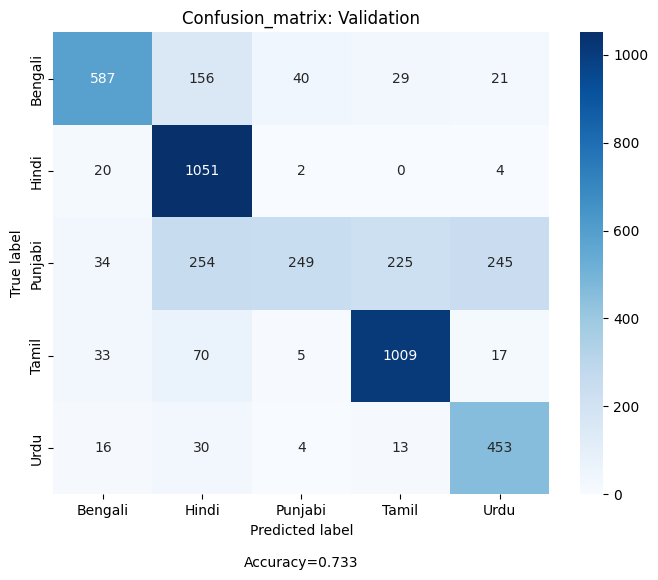

:::::Total vlidation loss 1.9484991986012103, Training accuracy 0.6785123054850458, Validation accuracy 0.7333041383840596 after 0 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 1, Batch: 0, Loss: 3.059522867202759, Accuracy:81.0%
Epoch: 1, Batch: 50, Loss: 2.5263538360595703, Accuracy:82.66666666666667%
Epoch: 1, Batch: 100, Loss: 2.5090537071228027, Accuracy:83.66666666666667%
#####TEST--in-domain:::::Epoch: 1, Batch: 0, Loss: 6.691196176689118e-05, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 1, Batch: 50, Loss: 0.3971882164478302, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 1, Batch: 100, Loss: 0.011029288172721863, Accuracy:100.0%


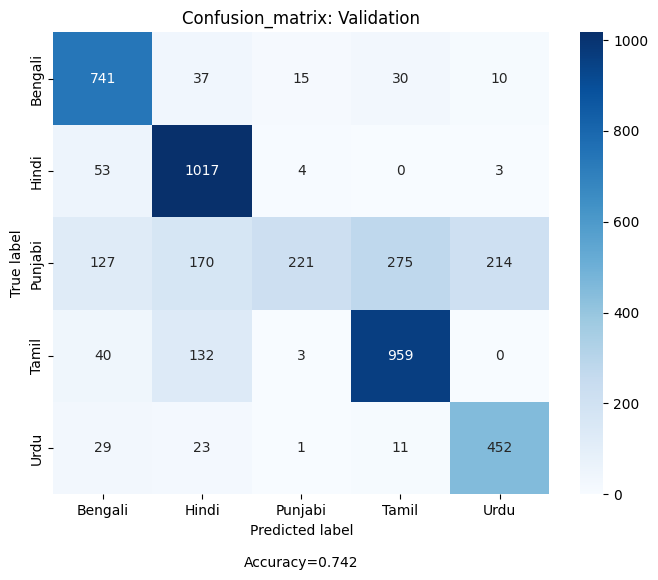

:::::Total vlidation loss 2.211296275115668, Training accuracy 0.8384284295331641, Validation accuracy 0.7422815852857456 after 1 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 2, Batch: 0, Loss: 1.8436726331710815, Accuracy:89.0%
Epoch: 2, Batch: 50, Loss: 1.8986856937408447, Accuracy:88.66666666666667%
Epoch: 2, Batch: 100, Loss: 1.7494844198226929, Accuracy:89.33333333333333%
#####TEST--in-domain:::::Epoch: 2, Batch: 0, Loss: 0.003180989995598793, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 2, Batch: 50, Loss: 0.11078985035419464, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 2, Batch: 100, Loss: 0.29759472608566284, Accuracy:93.75%


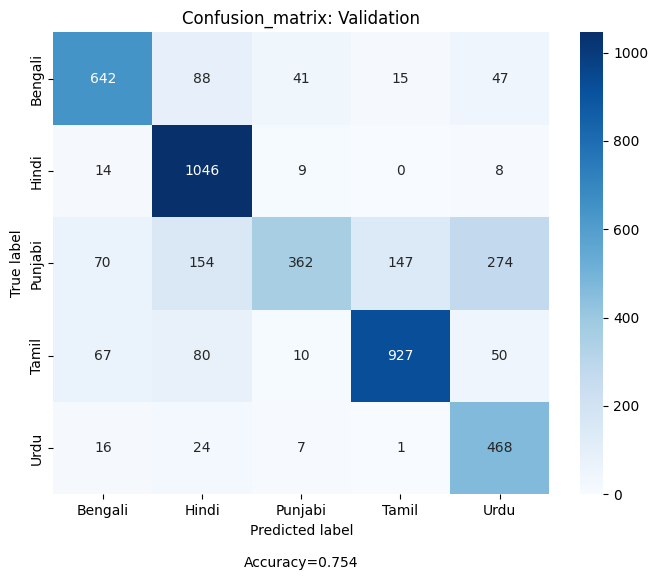

:::::Total vlidation loss 1.8277744518222527, Training accuracy 0.8878986866791745, Validation accuracy 0.754324501861178 after 2 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 3, Batch: 0, Loss: 1.1999009847640991, Accuracy:94.0%
Epoch: 3, Batch: 50, Loss: 1.2978345155715942, Accuracy:92.66666666666666%
Epoch: 3, Batch: 100, Loss: 1.2879756689071655, Accuracy:93.0%
#####TEST--in-domain:::::Epoch: 3, Batch: 0, Loss: 0.0014567018952220678, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 3, Batch: 50, Loss: 0.21400773525238037, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 3, Batch: 100, Loss: 3.009965439559892e-06, Accuracy:100.0%


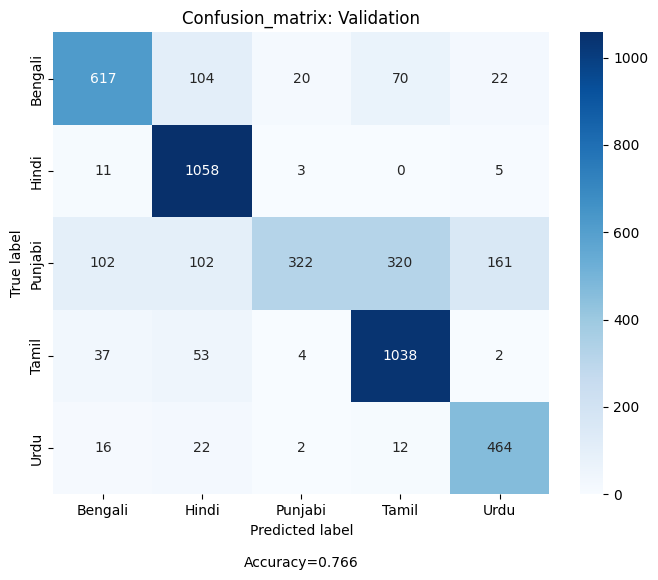

:::::Total vlidation loss 2.150312444488557, Training accuracy 0.9205937534488468, Validation accuracy 0.7661484563170572 after 3 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 4, Batch: 0, Loss: 1.0748515129089355, Accuracy:92.66666666666666%
Epoch: 4, Batch: 50, Loss: 0.8762367963790894, Accuracy:94.33333333333334%
Epoch: 4, Batch: 100, Loss: 1.0894079208374023, Accuracy:92.33333333333333%
#####TEST--in-domain:::::Epoch: 4, Batch: 0, Loss: 0.00046923168702051044, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 4, Batch: 50, Loss: 0.0016113176243379712, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 4, Batch: 100, Loss: 0.011523929424583912, Accuracy:100.0%


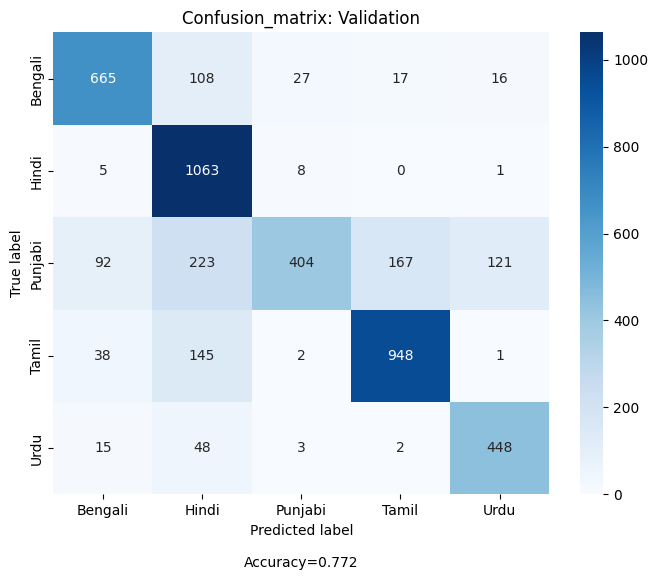

:::::Total vlidation loss 1.9907802645805852, Training accuracy 0.940872972078137, Validation accuracy 0.7724983577841034 after 4 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 5, Batch: 0, Loss: 0.6077482104301453, Accuracy:97.33333333333334%
Epoch: 5, Batch: 50, Loss: 0.821755588054657, Accuracy:94.66666666666667%
Epoch: 5, Batch: 100, Loss: 0.85952228307724, Accuracy:95.0%
#####TEST--in-domain:::::Epoch: 5, Batch: 0, Loss: 1.5646128304069862e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 5, Batch: 50, Loss: 0.00012838894326705486, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 5, Batch: 100, Loss: 0.14052289724349976, Accuracy:96.875%


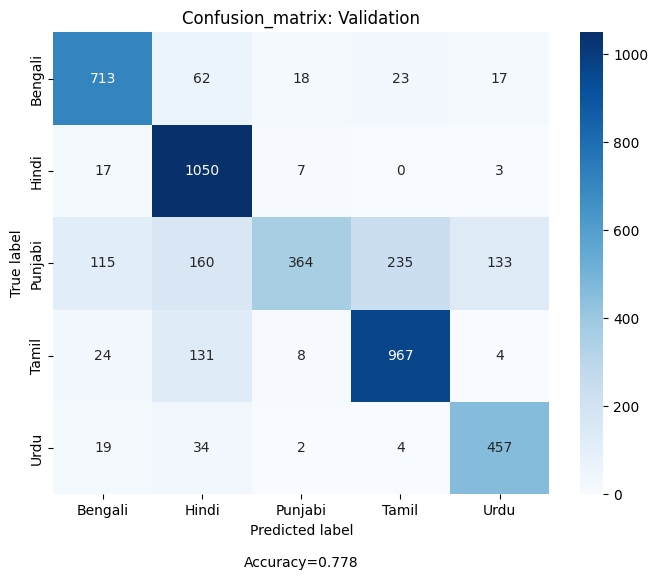

:::::Total vlidation loss 2.1343830196956897, Training accuracy 0.9659805760953537, Validation accuracy 0.7775344865338296 after 5 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 6, Batch: 0, Loss: 0.5451474785804749, Accuracy:97.0%
Epoch: 6, Batch: 50, Loss: 0.38938048481941223, Accuracy:98.0%
Epoch: 6, Batch: 100, Loss: 0.573916494846344, Accuracy:97.66666666666667%
#####TEST--in-domain:::::Epoch: 6, Batch: 0, Loss: 0.0009342054836452007, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 6, Batch: 50, Loss: 0.00010089665738632903, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 6, Batch: 100, Loss: 0.14984525740146637, Accuracy:96.875%


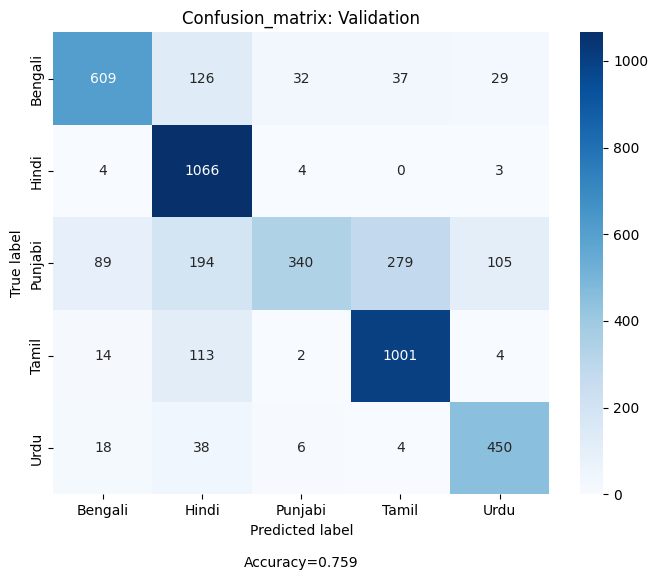

:::::Total vlidation loss 2.3372059096982563, Training accuracy 0.9754442114556893, Validation accuracy 0.7589227063717977 after 6 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 7, Batch: 0, Loss: 0.39296939969062805, Accuracy:98.33333333333333%
Epoch: 7, Batch: 50, Loss: 0.2878577411174774, Accuracy:99.33333333333333%
Epoch: 7, Batch: 100, Loss: 0.37814071774482727, Accuracy:98.0%
#####TEST--in-domain:::::Epoch: 7, Batch: 0, Loss: 0.0017915129428729415, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 7, Batch: 50, Loss: 1.5646179463146836e-07, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 7, Batch: 100, Loss: 1.3994497749081347e-05, Accuracy:100.0%


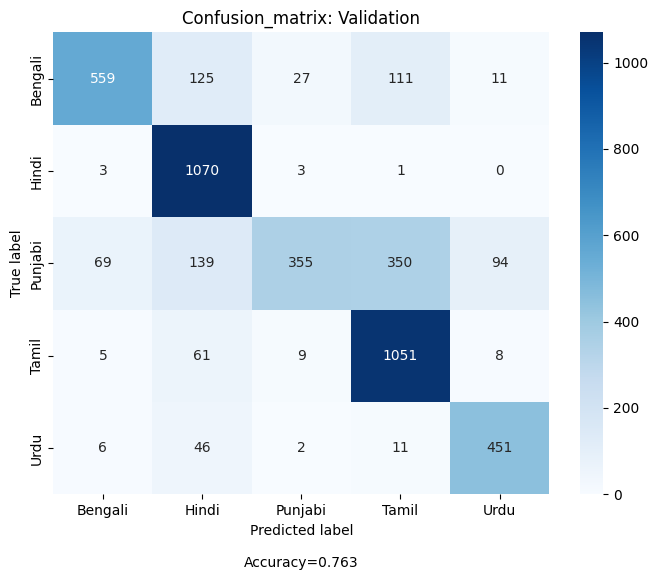

:::::Total vlidation loss 2.404641254781005, Training accuracy 0.9816797262995255, Validation accuracy 0.7633019487628641 after 7 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 8, Batch: 0, Loss: 0.3882421553134918, Accuracy:98.33333333333333%
Epoch: 8, Batch: 50, Loss: 0.38226014375686646, Accuracy:97.66666666666667%
Epoch: 8, Batch: 100, Loss: 0.37604764103889465, Accuracy:99.0%
#####TEST--in-domain:::::Epoch: 8, Batch: 0, Loss: 0.00013084620877634734, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 8, Batch: 50, Loss: 0.005236142780631781, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 8, Batch: 100, Loss: 0.004890887066721916, Accuracy:100.0%


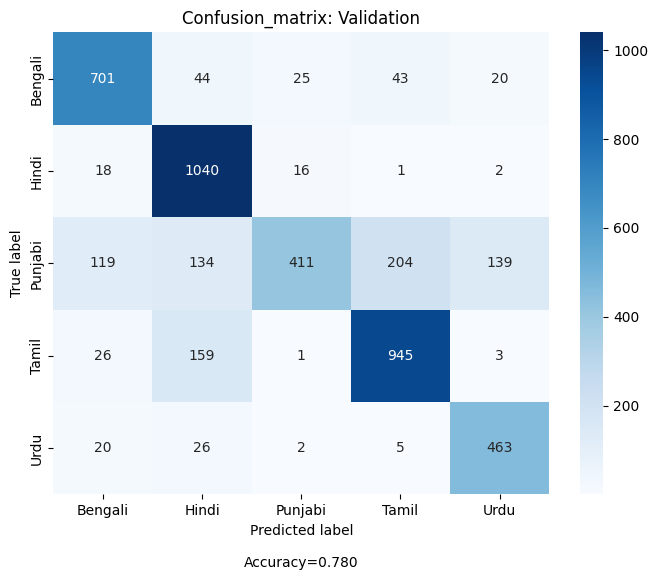

:::::Total vlidation loss 2.310211113242885, Training accuracy 0.9852389360997682, Validation accuracy 0.7795051456098095 after 8 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 9, Batch: 0, Loss: 0.2517247796058655, Accuracy:99.0%
Epoch: 9, Batch: 50, Loss: 0.2738621234893799, Accuracy:99.0%
Epoch: 9, Batch: 100, Loss: 0.24894832074642181, Accuracy:99.0%
#####TEST--in-domain:::::Epoch: 9, Batch: 0, Loss: 2.2390571757568978e-05, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 9, Batch: 50, Loss: 0.002578314859420061, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 9, Batch: 100, Loss: 0.00041096931090578437, Accuracy:100.0%


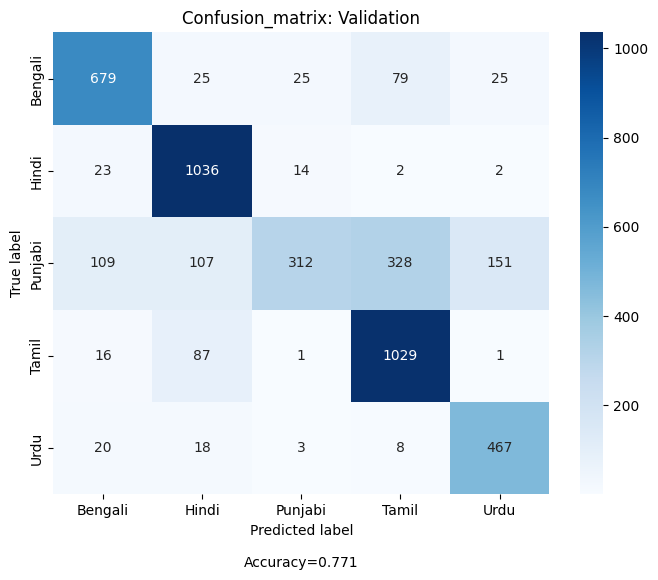

:::::Total vlidation loss 2.3976854830912995, Training accuracy 0.9905915461869551, Validation accuracy 0.7714035471863367 after 9 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 10, Batch: 0, Loss: 0.16009439527988434, Accuracy:100.0%
Epoch: 10, Batch: 50, Loss: 0.26979178190231323, Accuracy:99.66666666666667%
Epoch: 10, Batch: 100, Loss: 0.377300500869751, Accuracy:98.0%
#####TEST--in-domain:::::Epoch: 10, Batch: 0, Loss: 0.0008049874450080097, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 10, Batch: 50, Loss: 2.6408970370539464e-05, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 10, Batch: 100, Loss: 0.0007566730491816998, Accuracy:100.0%


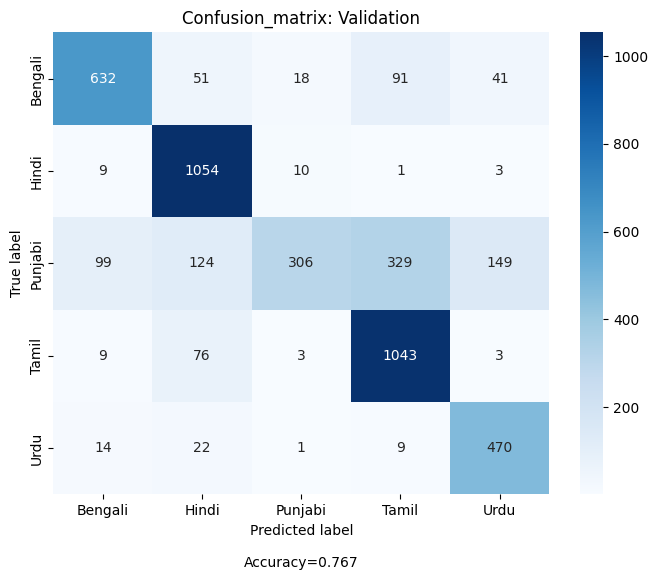

:::::Total vlidation loss 2.589969984341128, Training accuracy 0.9925229003421256, Validation accuracy 0.7674622290343771 after 10 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 11, Batch: 0, Loss: 0.20309321582317352, Accuracy:99.0%
Epoch: 11, Batch: 50, Loss: 0.1771169751882553, Accuracy:99.0%
Epoch: 11, Batch: 100, Loss: 0.20965485274791718, Accuracy:99.66666666666667%
#####TEST--in-domain:::::Epoch: 11, Batch: 0, Loss: 2.484733386154403e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 11, Batch: 50, Loss: 2.088072506012395e-05, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 11, Batch: 100, Loss: 0.004187908489257097, Accuracy:100.0%


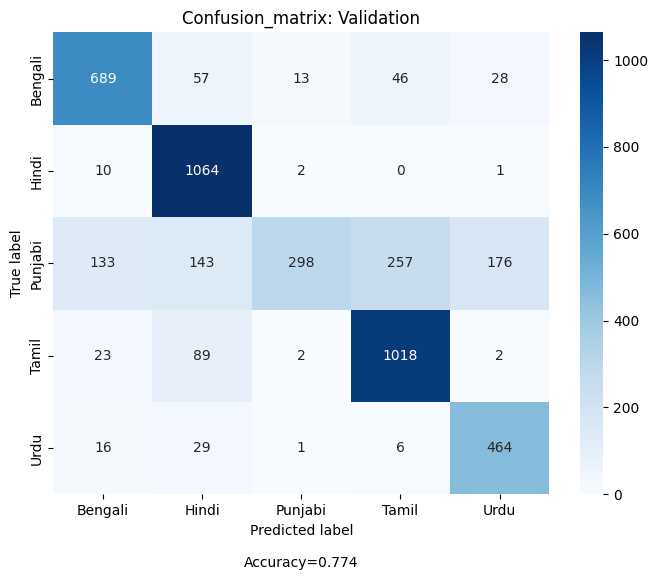

:::::Total vlidation loss 2.5400256178601692, Training accuracy 0.9944266637236508, Validation accuracy 0.77359316838187 after 11 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 12, Batch: 0, Loss: 0.0995771661400795, Accuracy:100.0%
Epoch: 12, Batch: 50, Loss: 0.08669692277908325, Accuracy:100.0%
Epoch: 12, Batch: 100, Loss: 0.10294444113969803, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 12, Batch: 0, Loss: 5.042221528128721e-05, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 12, Batch: 50, Loss: 2.2351734685344127e-08, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 12, Batch: 100, Loss: 0.01671154424548149, Accuracy:100.0%


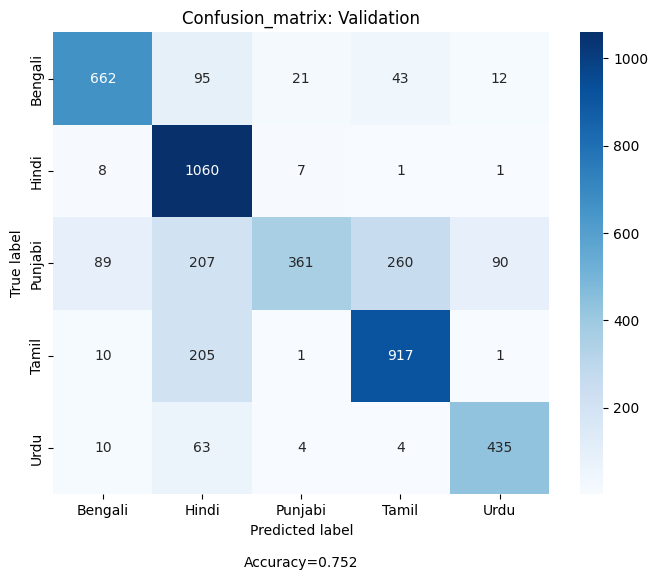

:::::Total vlidation loss 2.8192854708449726, Training accuracy 0.9960545193687231, Validation accuracy 0.7521348806656448 after 12 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 13, Batch: 0, Loss: 0.08165633678436279, Accuracy:100.0%
Epoch: 13, Batch: 50, Loss: 0.16015690565109253, Accuracy:99.33333333333333%
Epoch: 13, Batch: 100, Loss: 0.22669364511966705, Accuracy:99.33333333333333%
#####TEST--in-domain:::::Epoch: 13, Batch: 0, Loss: 0.08917602896690369, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 13, Batch: 50, Loss: 4.391808488435345e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 13, Batch: 100, Loss: 3.621702126110904e-05, Accuracy:100.0%


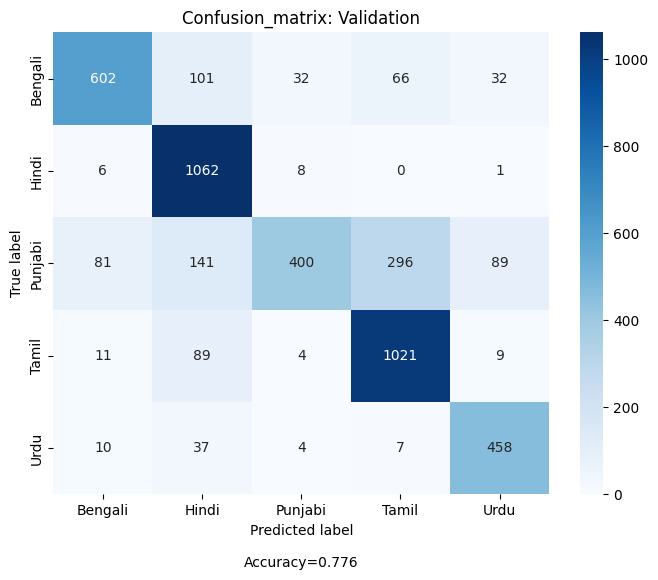

:::::Total vlidation loss 2.3997436620570585, Training accuracy 0.9971029687672442, Validation accuracy 0.7757827895774031 after 13 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 14, Batch: 0, Loss: 0.08346721529960632, Accuracy:99.66666666666667%
Epoch: 14, Batch: 50, Loss: 0.05037815868854523, Accuracy:100.0%
Epoch: 14, Batch: 100, Loss: 0.23980674147605896, Accuracy:98.33333333333333%
#####TEST--in-domain:::::Epoch: 14, Batch: 0, Loss: 6.0269808273005765e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 14, Batch: 50, Loss: 1.4067330994294025e-05, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 14, Batch: 100, Loss: 0.0002579420106485486, Accuracy:100.0%


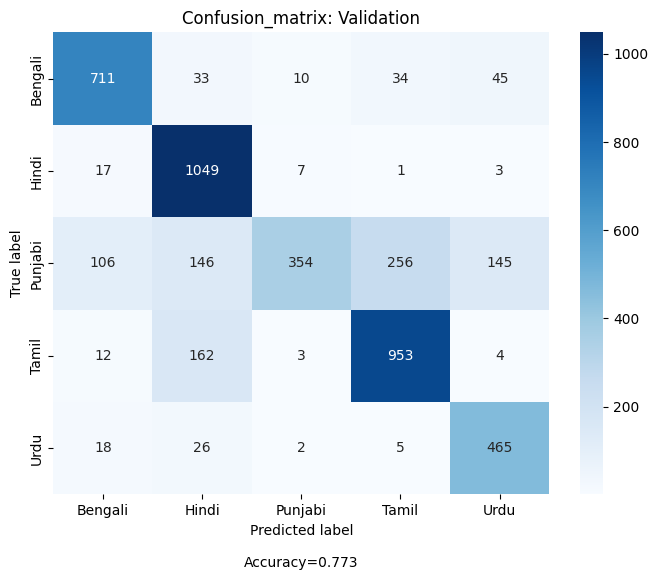

:::::Total vlidation loss 2.778017908715062, Training accuracy 0.9977927381083765, Validation accuracy 0.7733742062623166 after 14 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 15, Batch: 0, Loss: 0.07169082760810852, Accuracy:100.0%
Epoch: 15, Batch: 50, Loss: 0.038805197924375534, Accuracy:100.0%
Epoch: 15, Batch: 100, Loss: 0.04153086617588997, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 15, Batch: 0, Loss: 0.004596484359353781, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 15, Batch: 50, Loss: 1.117567194341973e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 15, Batch: 100, Loss: 0.0002499583060853183, Accuracy:100.0%


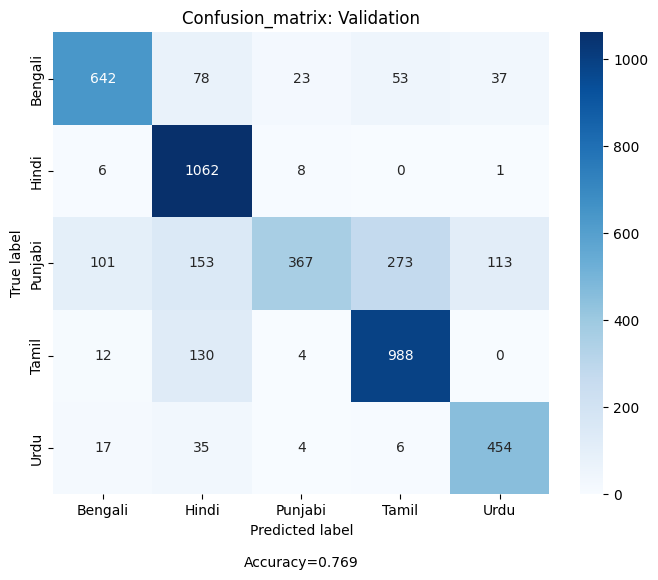

:::::Total vlidation loss 2.65653088869812, Training accuracy 0.9992274583379318, Validation accuracy 0.7692139259908036 after 15 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 16, Batch: 0, Loss: 0.04300708696246147, Accuracy:100.0%
Epoch: 16, Batch: 50, Loss: 0.05715362727642059, Accuracy:100.0%
Epoch: 16, Batch: 100, Loss: 0.016431646421551704, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 16, Batch: 0, Loss: 0.00284929689951241, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 16, Batch: 50, Loss: 0.0001916956971399486, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 16, Batch: 100, Loss: 0.000144055942655541, Accuracy:100.0%


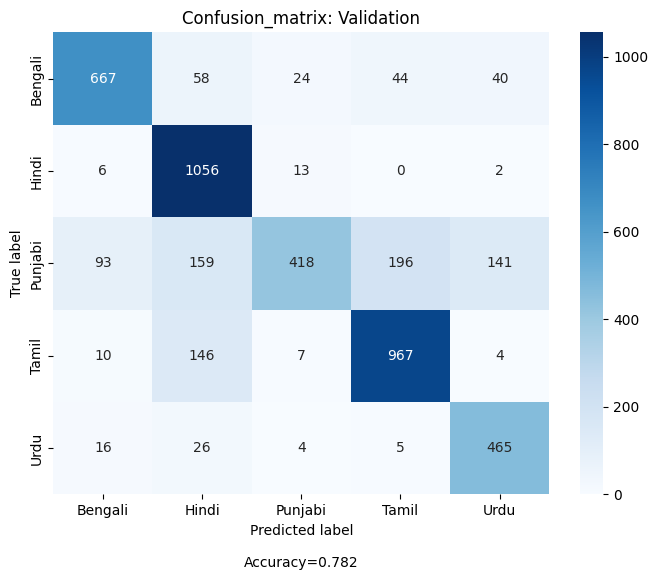

:::::Total vlidation loss 2.406595555039449, Training accuracy 0.9996413199426112, Validation accuracy 0.7823516531640027 after 16 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 17, Batch: 0, Loss: 0.020640844479203224, Accuracy:100.0%
Epoch: 17, Batch: 50, Loss: 0.03698127716779709, Accuracy:100.0%
Epoch: 17, Batch: 100, Loss: 0.02460707537829876, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 17, Batch: 0, Loss: 0.0007124338299036026, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 17, Batch: 50, Loss: 2.6820941911864793e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 17, Batch: 100, Loss: 0.0005165173788554966, Accuracy:100.0%


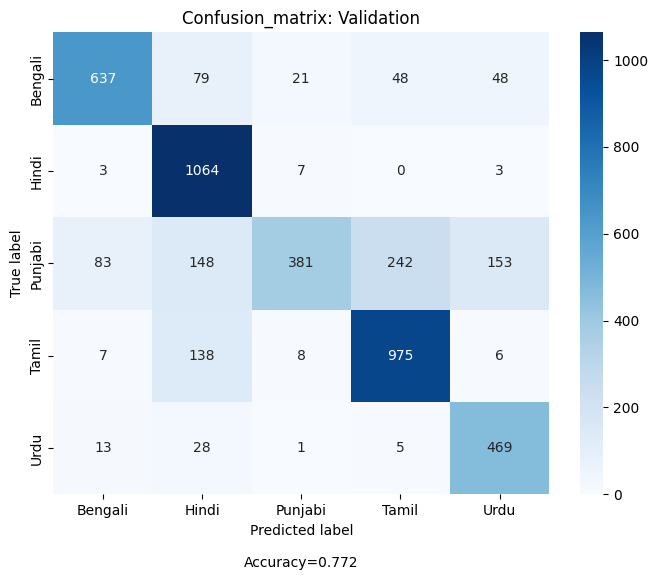

:::::Total vlidation loss 2.6321706939054175, Training accuracy 0.9996413199426112, Validation accuracy 0.7720604335449968 after 17 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 18, Batch: 0, Loss: 0.03701194003224373, Accuracy:100.0%
Epoch: 18, Batch: 50, Loss: 0.03495577722787857, Accuracy:100.0%
Epoch: 18, Batch: 100, Loss: 0.011250670999288559, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 18, Batch: 0, Loss: 0.0007242136052809656, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 18, Batch: 50, Loss: 7.718949200352654e-05, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 18, Batch: 100, Loss: 0.00010797947470564395, Accuracy:100.0%


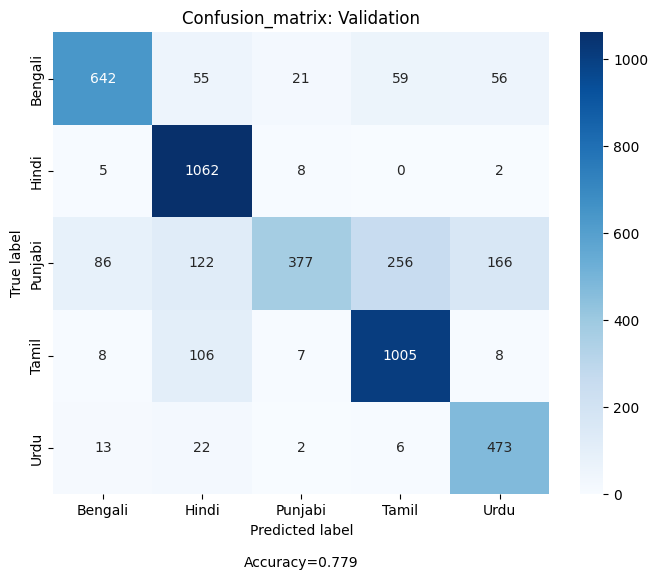

:::::Total vlidation loss 2.5102852592991436, Training accuracy 0.9997516830371924, Validation accuracy 0.7792861834902561 after 18 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 19, Batch: 0, Loss: 0.02764837257564068, Accuracy:100.0%
Epoch: 19, Batch: 50, Loss: 0.021215619519352913, Accuracy:100.0%
Epoch: 19, Batch: 100, Loss: 0.00830514170229435, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 19, Batch: 0, Loss: 0.0011931490153074265, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 19, Batch: 50, Loss: 3.3116075428551994e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 19, Batch: 100, Loss: 0.031164078041911125, Accuracy:96.875%


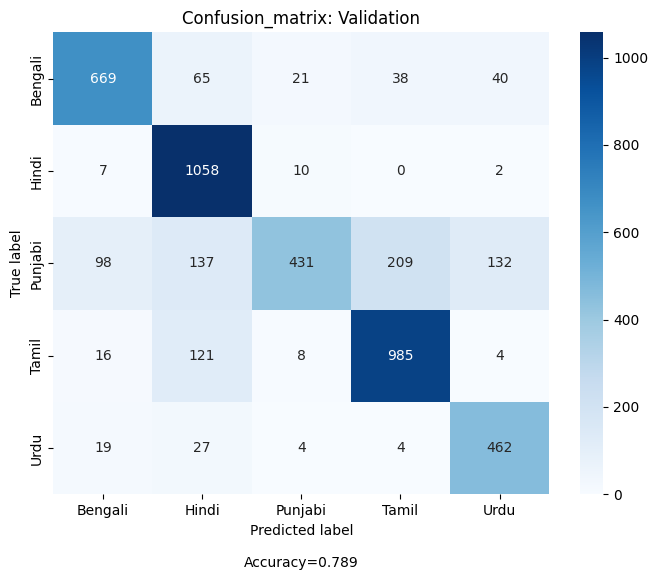

:::::Total vlidation loss 2.326685052616388, Training accuracy 0.9998896369054189, Validation accuracy 0.7893584409897088 after 19 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 20, Batch: 0, Loss: 0.012004750780761242, Accuracy:100.0%
Epoch: 20, Batch: 50, Loss: 0.009571442380547523, Accuracy:100.0%
Epoch: 20, Batch: 100, Loss: 0.024388426914811134, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 20, Batch: 0, Loss: 0.0008730023982934654, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 20, Batch: 50, Loss: 1.489761325501604e-05, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 20, Batch: 100, Loss: 0.0002491429913789034, Accuracy:100.0%


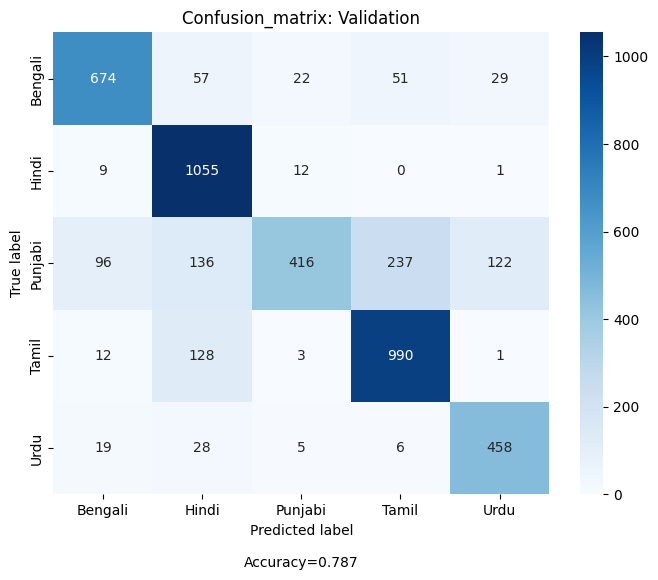

:::::Total vlidation loss 2.4063366280929883, Training accuracy 0.9999172276790641, Validation accuracy 0.7867308955550689 after 20 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 21, Batch: 0, Loss: 0.04117325320839882, Accuracy:99.66666666666667%
Epoch: 21, Batch: 50, Loss: 0.01019477192312479, Accuracy:100.0%
Epoch: 21, Batch: 100, Loss: 0.01311330683529377, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 21, Batch: 0, Loss: 0.0004372329858597368, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 21, Batch: 50, Loss: 1.2404972267177072e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 21, Batch: 100, Loss: 0.00017136162205133587, Accuracy:100.0%


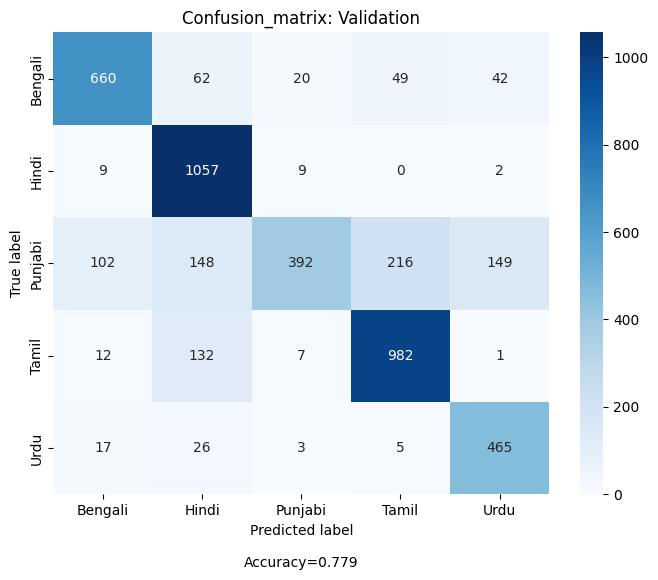

:::::Total vlidation loss 2.5462455100745394, Training accuracy 0.9999172276790641, Validation accuracy 0.7786292971315962 after 21 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 22, Batch: 0, Loss: 0.008419308811426163, Accuracy:100.0%
Epoch: 22, Batch: 50, Loss: 0.00724576972424984, Accuracy:100.0%
Epoch: 22, Batch: 100, Loss: 0.01831422559916973, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 22, Batch: 0, Loss: 0.00046567647950723767, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 22, Batch: 50, Loss: 1.5132191947486717e-05, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 22, Batch: 100, Loss: 0.0020323179196566343, Accuracy:100.0%


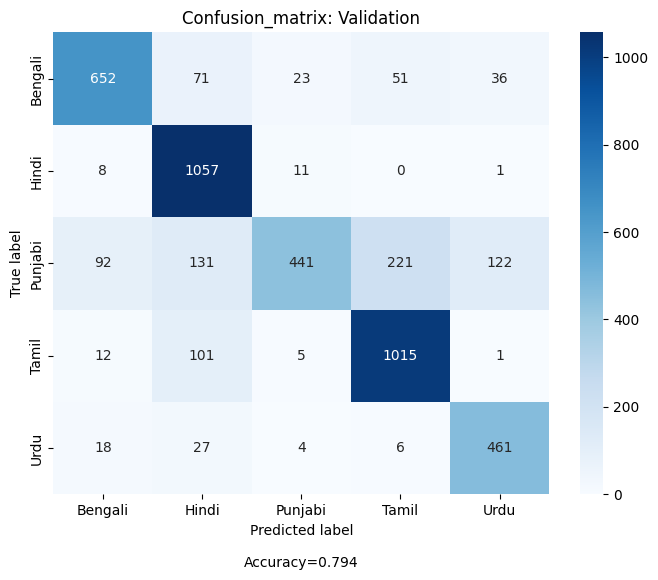

:::::Total vlidation loss 2.227487677564066, Training accuracy 0.9999172276790641, Validation accuracy 0.7939566455003284 after 22 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 23, Batch: 0, Loss: 0.015188143588602543, Accuracy:100.0%
Epoch: 23, Batch: 50, Loss: 0.005010594148188829, Accuracy:100.0%
Epoch: 23, Batch: 100, Loss: 0.014217189513146877, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 23, Batch: 0, Loss: 0.0002842194808181375, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 23, Batch: 50, Loss: 9.498047802480869e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 23, Batch: 100, Loss: 0.0023452260065823793, Accuracy:100.0%


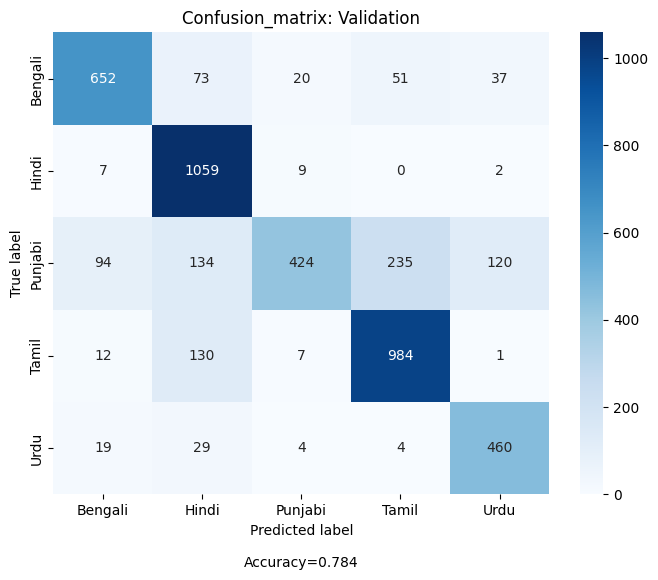

:::::Total vlidation loss 2.4519151041561136, Training accuracy 0.9999724092263547, Validation accuracy 0.7836654258813225 after 23 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 24, Batch: 0, Loss: 0.00752180116251111, Accuracy:100.0%
Epoch: 24, Batch: 50, Loss: 0.0033202727790921926, Accuracy:100.0%
Epoch: 24, Batch: 100, Loss: 0.006273604929447174, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 24, Batch: 0, Loss: 0.00046651874436065555, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 24, Batch: 50, Loss: 1.296374080084206e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 24, Batch: 100, Loss: 0.001471092109568417, Accuracy:100.0%


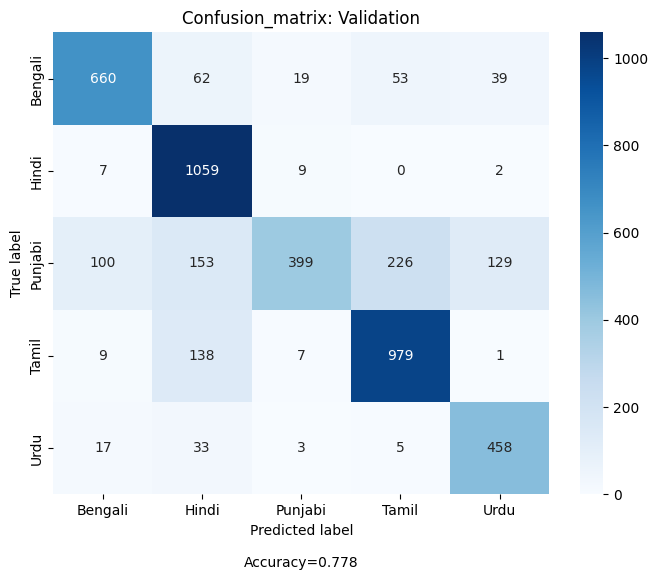

:::::Total vlidation loss 2.538342581191933, Training accuracy 0.9999724092263547, Validation accuracy 0.7784103350120429 after 24 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 25, Batch: 0, Loss: 0.016923842951655388, Accuracy:100.0%
Epoch: 25, Batch: 50, Loss: 0.013740546070039272, Accuracy:100.0%
Epoch: 25, Batch: 100, Loss: 0.005093904212117195, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 25, Batch: 0, Loss: 0.00038563922862522304, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 25, Batch: 50, Loss: 1.855139544204576e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 25, Batch: 100, Loss: 0.0003775463264901191, Accuracy:100.0%


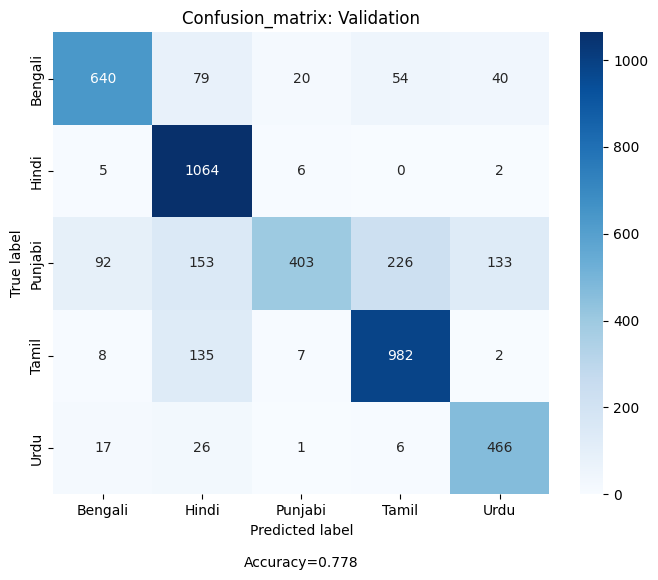

:::::Total vlidation loss 2.5335491956963923, Training accuracy 0.9999448184527094, Validation accuracy 0.7784103350120429 after 25 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 26, Batch: 0, Loss: 0.010767180472612381, Accuracy:100.0%
Epoch: 26, Batch: 50, Loss: 0.01152297854423523, Accuracy:100.0%
Epoch: 26, Batch: 100, Loss: 0.009146194905042648, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 26, Batch: 0, Loss: 0.0019266133895143867, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 26, Batch: 50, Loss: 2.555444552854169e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 26, Batch: 100, Loss: 0.0023019711952656507, Accuracy:100.0%


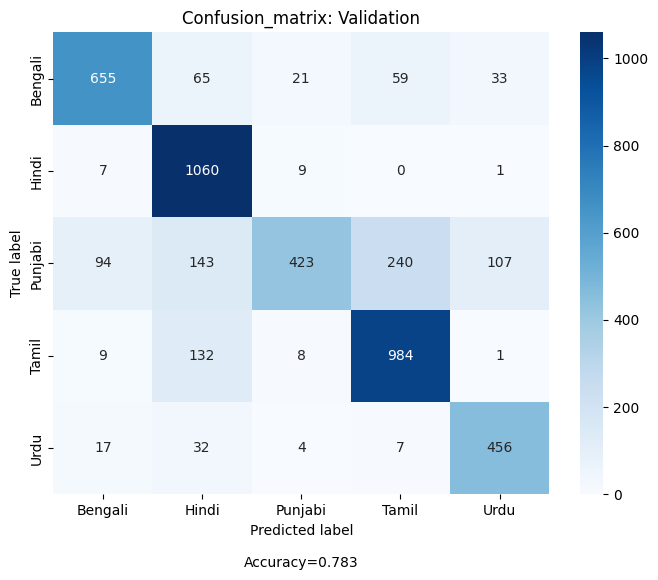

:::::Total vlidation loss 2.48652496859167, Training accuracy 1.0, Validation accuracy 0.7834464637617692 after 26 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 27, Batch: 0, Loss: 0.022237636148929596, Accuracy:100.0%
Epoch: 27, Batch: 50, Loss: 0.007223880384117365, Accuracy:100.0%
Epoch: 27, Batch: 100, Loss: 0.007913107983767986, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 27, Batch: 0, Loss: 0.00227150646969676, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 27, Batch: 50, Loss: 9.166596100840252e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 27, Batch: 100, Loss: 0.0016373315593227744, Accuracy:100.0%


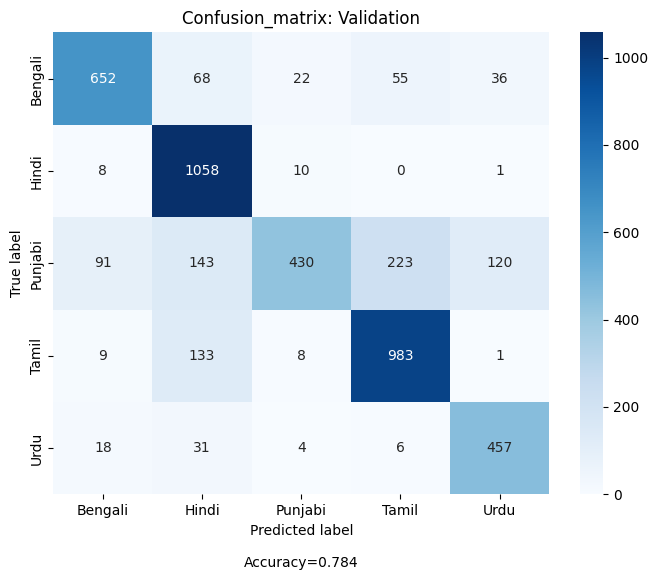

:::::Total vlidation loss 2.4400837840683445, Training accuracy 1.0, Validation accuracy 0.7838843880008759 after 27 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 28, Batch: 0, Loss: 0.003451739903539419, Accuracy:100.0%
Epoch: 28, Batch: 50, Loss: 0.0033849359024316072, Accuracy:100.0%
Epoch: 28, Batch: 100, Loss: 0.005422978196293116, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 28, Batch: 0, Loss: 0.001080702873878181, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 28, Batch: 50, Loss: 5.445899660116993e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 28, Batch: 100, Loss: 0.0014518719399347901, Accuracy:100.0%


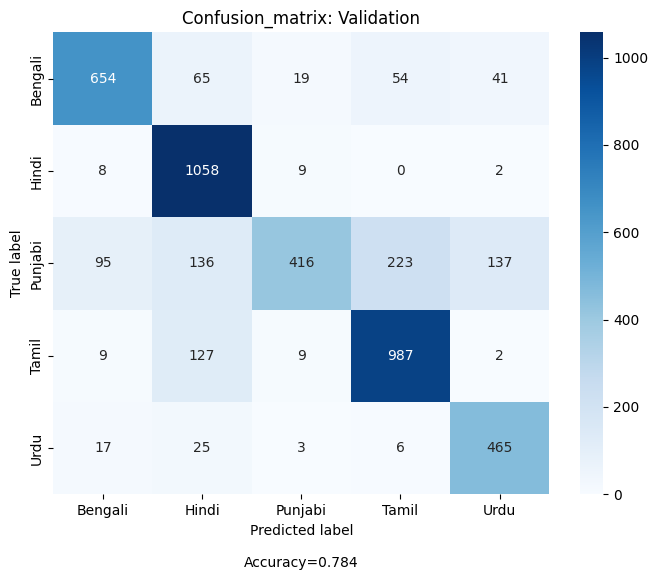

:::::Total vlidation loss 2.4155126232445157, Training accuracy 1.0, Validation accuracy 0.7838843880008759 after 28 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 29, Batch: 0, Loss: 0.003668786259368062, Accuracy:100.0%
Epoch: 29, Batch: 50, Loss: 0.01622227393090725, Accuracy:100.0%
Epoch: 29, Batch: 100, Loss: 0.013195679523050785, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 29, Batch: 0, Loss: 0.001362168462947011, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 29, Batch: 50, Loss: 4.734486083179945e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 29, Batch: 100, Loss: 0.0005801914958283305, Accuracy:100.0%


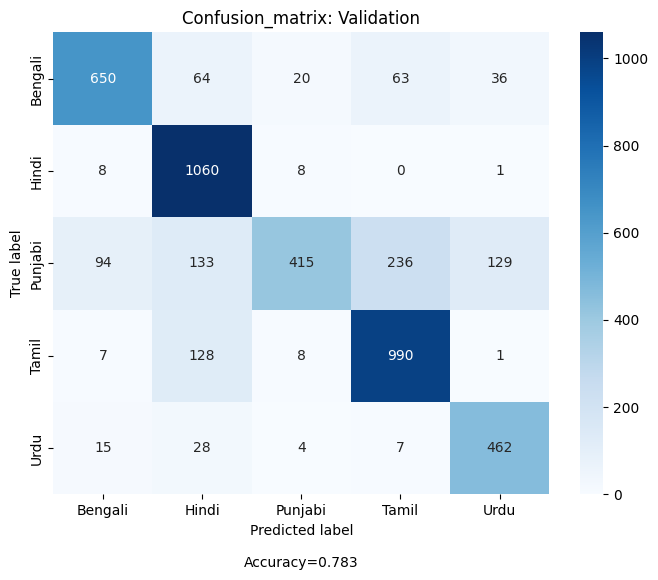

:::::Total vlidation loss 2.4717258801529076, Training accuracy 0.9999724092263547, Validation accuracy 0.7832275016422159 after 29 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 30, Batch: 0, Loss: 0.004957528319209814, Accuracy:100.0%
Epoch: 30, Batch: 50, Loss: 0.002395095070824027, Accuracy:100.0%
Epoch: 30, Batch: 100, Loss: 0.00897970236837864, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 30, Batch: 0, Loss: 0.0012899399735033512, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 30, Batch: 50, Loss: 2.1680436930182623e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 30, Batch: 100, Loss: 0.0017664080951362848, Accuracy:100.0%


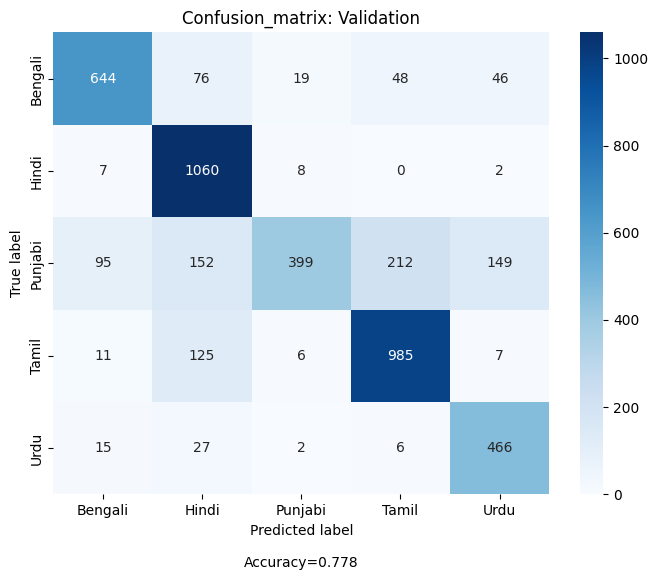

:::::Total vlidation loss 2.5812327534669155, Training accuracy 0.9999448184527094, Validation accuracy 0.7781913728924896 after 30 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 31, Batch: 0, Loss: 0.009636716917157173, Accuracy:100.0%
Epoch: 31, Batch: 50, Loss: 0.00770627660676837, Accuracy:100.0%
Epoch: 31, Batch: 100, Loss: 0.005322953686118126, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 31, Batch: 0, Loss: 0.002499963855370879, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 31, Batch: 50, Loss: 7.674003654756234e-07, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 31, Batch: 100, Loss: 0.0005490509211085737, Accuracy:100.0%


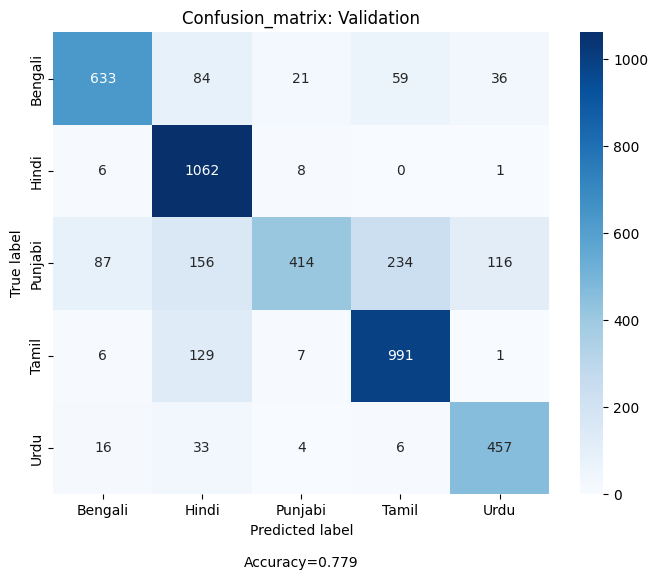

:::::Total vlidation loss 2.5131024774150124, Training accuracy 1.0, Validation accuracy 0.7788482592511495 after 31 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 32, Batch: 0, Loss: 0.0038525613490492105, Accuracy:100.0%
Epoch: 32, Batch: 50, Loss: 0.004922834224998951, Accuracy:100.0%
Epoch: 32, Batch: 100, Loss: 0.013902352191507816, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 32, Batch: 0, Loss: 0.005163520108908415, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 32, Batch: 50, Loss: 5.699642429135565e-07, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 32, Batch: 100, Loss: 3.789189941016957e-05, Accuracy:100.0%


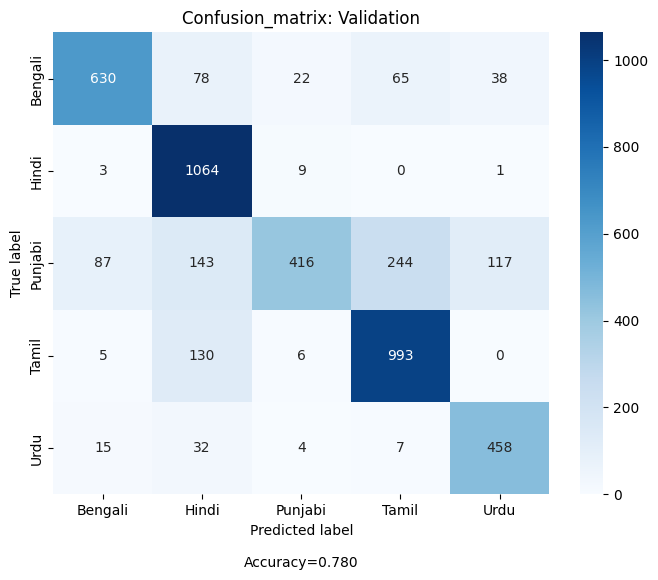

:::::Total vlidation loss 2.5554338949772637, Training accuracy 0.9999724092263547, Validation accuracy 0.7797241077293628 after 32 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 33, Batch: 0, Loss: 0.005018148105591536, Accuracy:100.0%
Epoch: 33, Batch: 50, Loss: 0.007432535290718079, Accuracy:100.0%
Epoch: 33, Batch: 100, Loss: 0.008013381622731686, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 33, Batch: 0, Loss: 0.0016339931171387434, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 33, Batch: 50, Loss: 4.015605099993991e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 33, Batch: 100, Loss: 0.0003012734232470393, Accuracy:100.0%


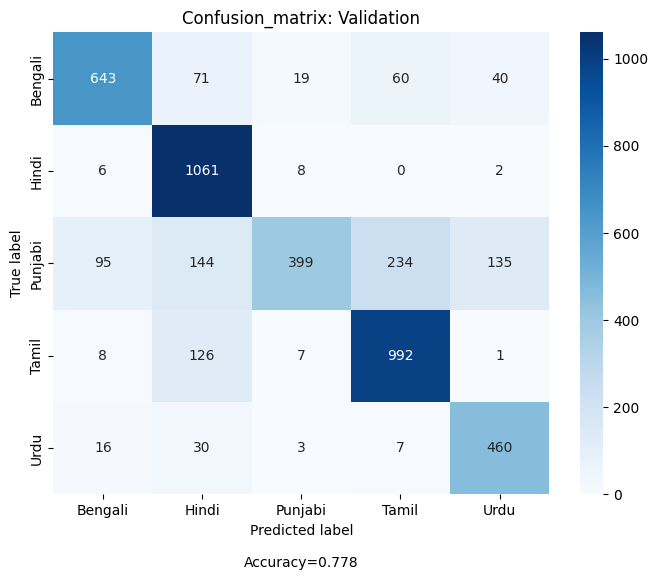

:::::Total vlidation loss 2.5276468983134275, Training accuracy 0.9999724092263547, Validation accuracy 0.7784103350120429 after 33 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 34, Batch: 0, Loss: 0.0032251127995550632, Accuracy:100.0%
Epoch: 34, Batch: 50, Loss: 0.010419935919344425, Accuracy:100.0%
Epoch: 34, Batch: 100, Loss: 0.028182560577988625, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 34, Batch: 0, Loss: 0.0006168343825265765, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 34, Batch: 50, Loss: 3.7474173950613476e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 34, Batch: 100, Loss: 0.00024146269424818456, Accuracy:100.0%


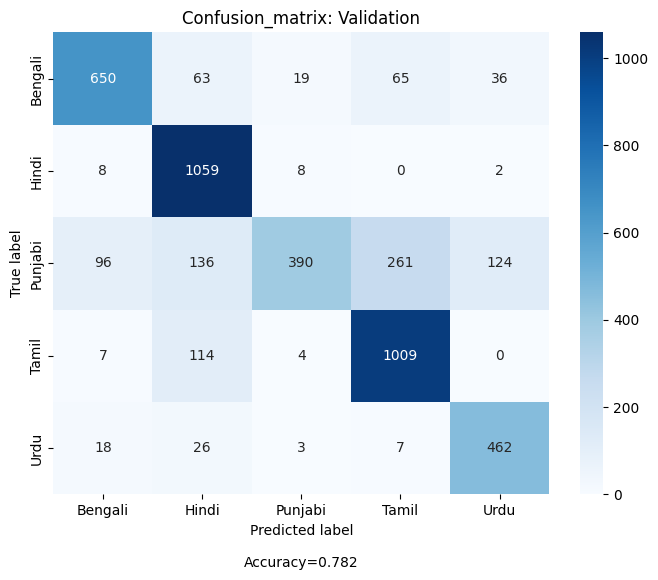

:::::Total vlidation loss 2.5695761303315554, Training accuracy 1.0, Validation accuracy 0.7816947668053427 after 34 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 35, Batch: 0, Loss: 0.0020731633994728327, Accuracy:100.0%
Epoch: 35, Batch: 50, Loss: 0.003529977286234498, Accuracy:100.0%
Epoch: 35, Batch: 100, Loss: 0.004064347594976425, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 35, Batch: 0, Loss: 0.0021438198164105415, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 35, Batch: 50, Loss: 4.332212938606972e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 35, Batch: 100, Loss: 0.0004699723795056343, Accuracy:100.0%


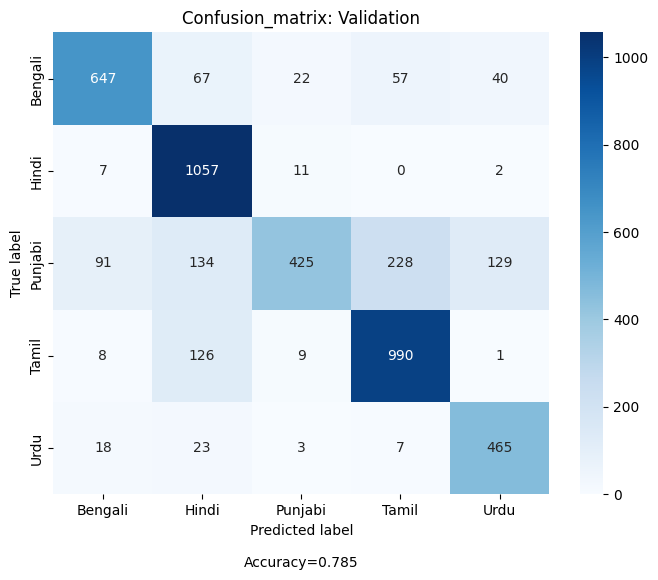

:::::Total vlidation loss 2.452446961683166, Training accuracy 1.0, Validation accuracy 0.7847602364790891 after 35 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 36, Batch: 0, Loss: 0.0033803104888647795, Accuracy:100.0%
Epoch: 36, Batch: 50, Loss: 0.0034752150531858206, Accuracy:100.0%
Epoch: 36, Batch: 100, Loss: 0.01487224455922842, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 36, Batch: 0, Loss: 0.0027503459714353085, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 36, Batch: 50, Loss: 2.6299446744815214e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 36, Batch: 100, Loss: 0.001475897035561502, Accuracy:100.0%


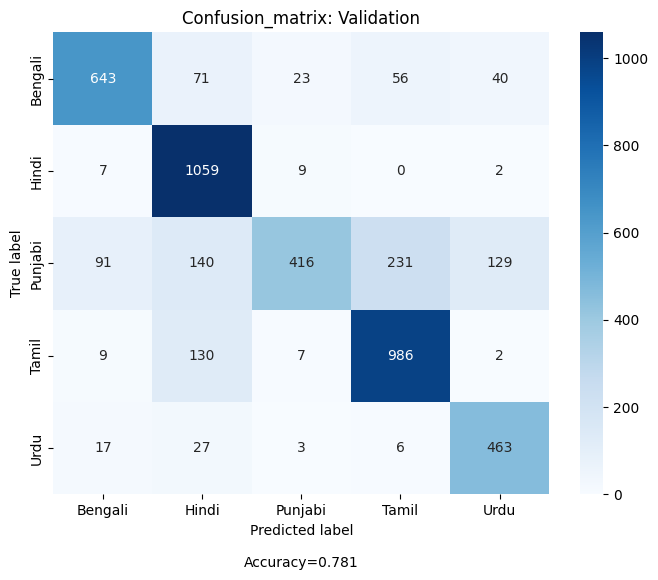

:::::Total vlidation loss 2.486859478725885, Training accuracy 1.0, Validation accuracy 0.7810378804466828 after 36 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 37, Batch: 0, Loss: 0.004412701353430748, Accuracy:100.0%
Epoch: 37, Batch: 50, Loss: 0.021352015435695648, Accuracy:100.0%
Epoch: 37, Batch: 100, Loss: 0.005127829499542713, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 37, Batch: 0, Loss: 0.002262148540467024, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 37, Batch: 50, Loss: 1.0542394193180371e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 37, Batch: 100, Loss: 0.000200648297322914, Accuracy:100.0%


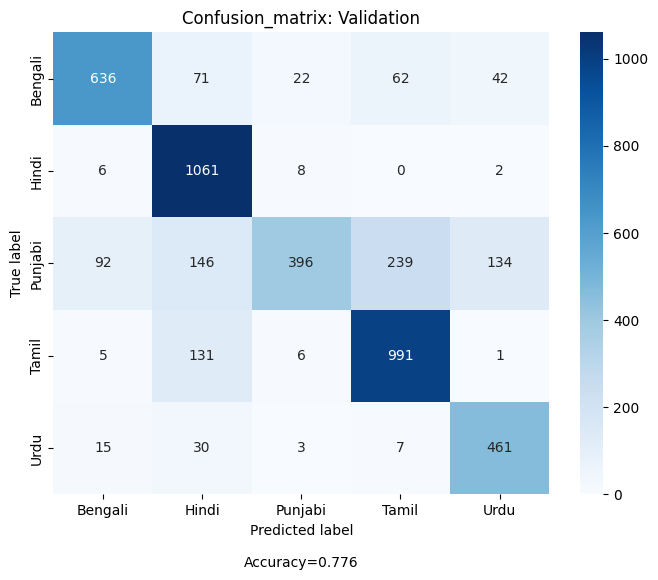

:::::Total vlidation loss 2.6154196908212457, Training accuracy 1.0, Validation accuracy 0.7762207138165097 after 37 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 38, Batch: 0, Loss: 0.018158212304115295, Accuracy:100.0%
Epoch: 38, Batch: 50, Loss: 0.019798116758465767, Accuracy:100.0%
Epoch: 38, Batch: 100, Loss: 0.0034404946491122246, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 38, Batch: 0, Loss: 0.0019661292899399996, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 38, Batch: 50, Loss: 1.449104274797719e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 38, Batch: 100, Loss: 0.00014311949780676514, Accuracy:100.0%


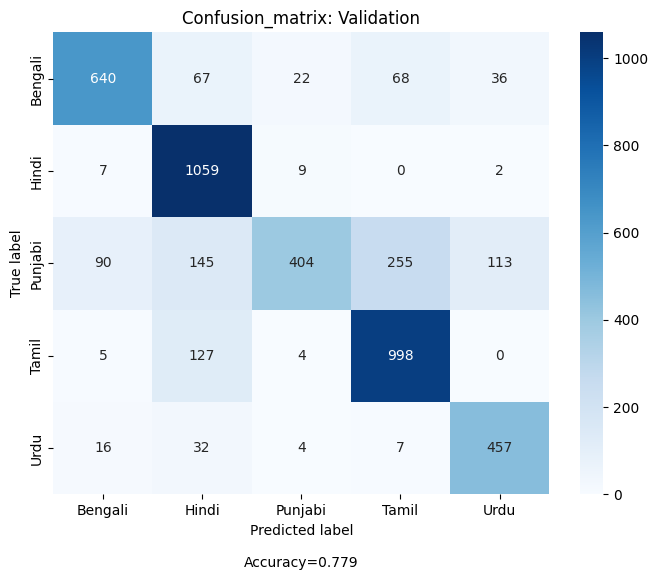

:::::Total vlidation loss 2.561869808007536, Training accuracy 1.0, Validation accuracy 0.7790672213707028 after 38 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 39, Batch: 0, Loss: 0.0017124133883044124, Accuracy:100.0%
Epoch: 39, Batch: 50, Loss: 0.004261031746864319, Accuracy:100.0%
Epoch: 39, Batch: 100, Loss: 0.0057773166336119175, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 39, Batch: 0, Loss: 0.0012559103779494762, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 39, Batch: 50, Loss: 2.6634691039362224e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 39, Batch: 100, Loss: 0.0009608498658053577, Accuracy:100.0%


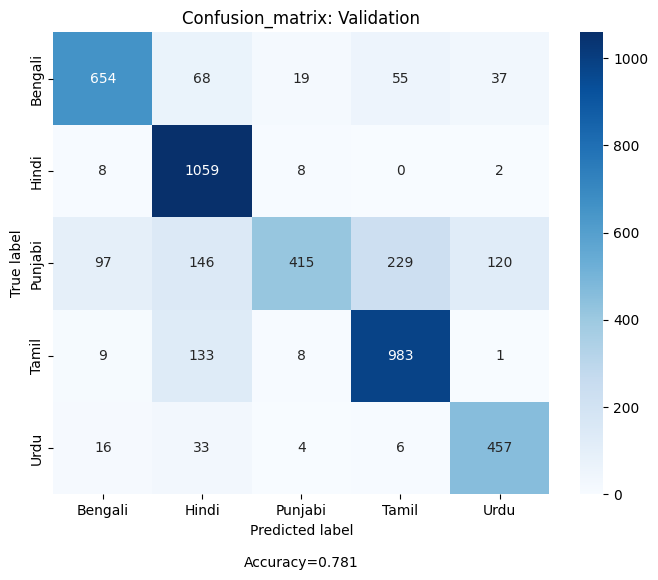

:::::Total vlidation loss 2.498505037369407, Training accuracy 0.9999724092263547, Validation accuracy 0.7812568425662361 after 39 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 40, Batch: 0, Loss: 0.01061431597918272, Accuracy:100.0%
Epoch: 40, Batch: 50, Loss: 0.001957574626430869, Accuracy:100.0%
Epoch: 40, Batch: 100, Loss: 0.007425317075103521, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 40, Batch: 0, Loss: 0.0019784830510616302, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 40, Batch: 50, Loss: 1.3113996828906238e-05, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 40, Batch: 100, Loss: 0.00037726061418652534, Accuracy:100.0%


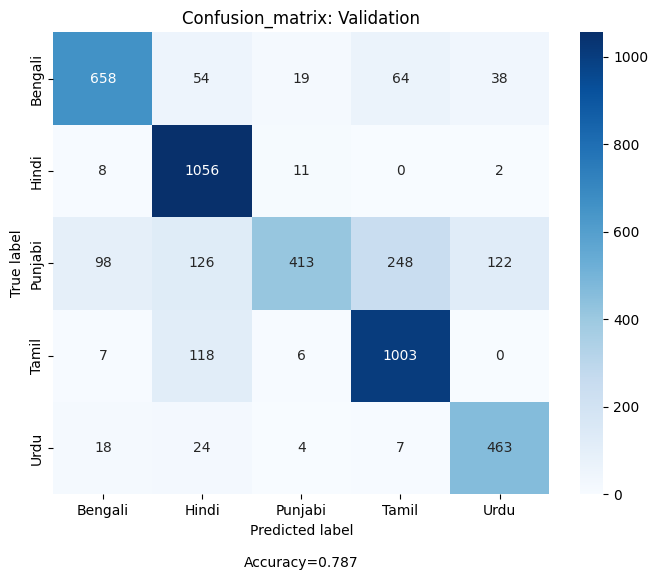

:::::Total vlidation loss 2.4705362027244453, Training accuracy 1.0, Validation accuracy 0.7867308955550689 after 40 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 41, Batch: 0, Loss: 0.02237558178603649, Accuracy:100.0%
Epoch: 41, Batch: 50, Loss: 0.001977750798687339, Accuracy:100.0%
Epoch: 41, Batch: 100, Loss: 0.0055061993189156055, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 41, Batch: 0, Loss: 0.004781815223395824, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 41, Batch: 50, Loss: 1.7471122646384174e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 41, Batch: 100, Loss: 0.000809069664683193, Accuracy:100.0%


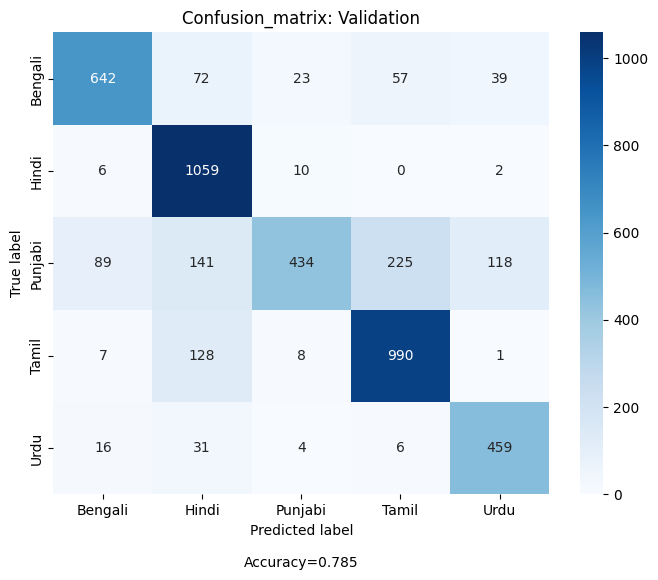

:::::Total vlidation loss 2.4400824881207983, Training accuracy 1.0, Validation accuracy 0.7847602364790891 after 41 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 42, Batch: 0, Loss: 0.007828698493540287, Accuracy:100.0%
Epoch: 42, Batch: 50, Loss: 0.011280830949544907, Accuracy:100.0%
Epoch: 42, Batch: 100, Loss: 0.008325823582708836, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 42, Batch: 0, Loss: 0.0028219856321811676, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 42, Batch: 50, Loss: 1.814163738345087e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 42, Batch: 100, Loss: 0.0005065660807304084, Accuracy:100.0%


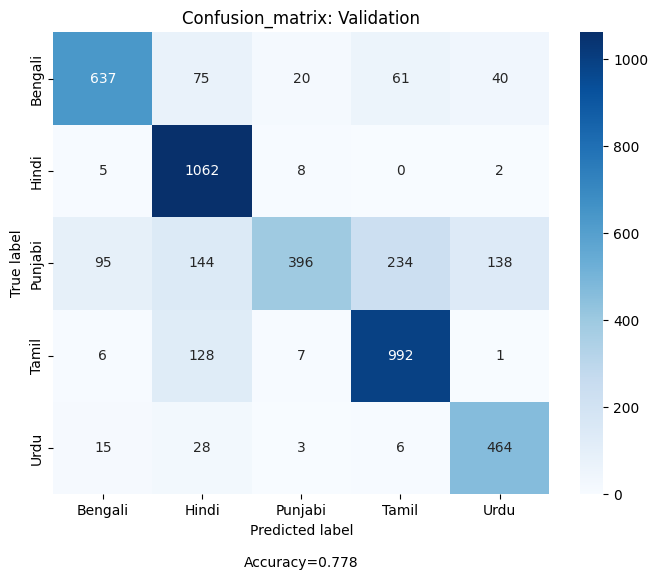

:::::Total vlidation loss 2.565417913409228, Training accuracy 1.0, Validation accuracy 0.7775344865338296 after 42 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 43, Batch: 0, Loss: 0.003150408621877432, Accuracy:100.0%
Epoch: 43, Batch: 50, Loss: 0.0029394447337836027, Accuracy:100.0%
Epoch: 43, Batch: 100, Loss: 0.007245112210512161, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 43, Batch: 0, Loss: 0.0051208133809268475, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 43, Batch: 50, Loss: 1.6428098206233699e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 43, Batch: 100, Loss: 0.000151917411130853, Accuracy:100.0%


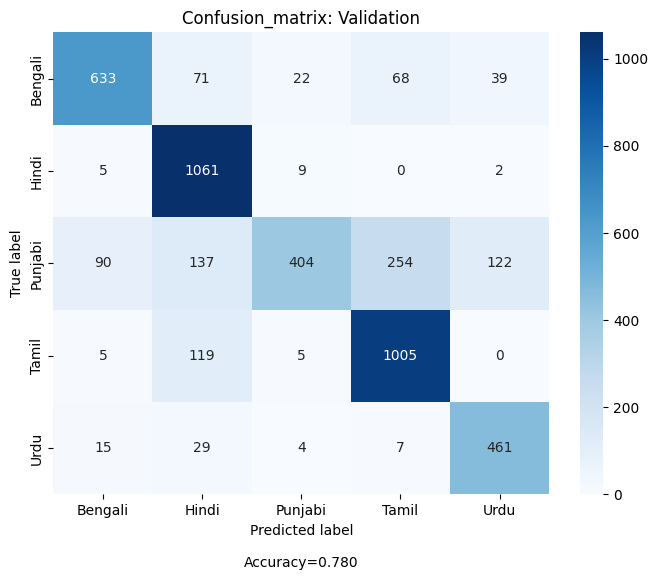

:::::Total vlidation loss 2.5727808143184943, Training accuracy 0.9999724092263547, Validation accuracy 0.7803809940880228 after 43 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 44, Batch: 0, Loss: 0.01208366360515356, Accuracy:100.0%
Epoch: 44, Batch: 50, Loss: 0.003436545841395855, Accuracy:100.0%
Epoch: 44, Batch: 100, Loss: 0.010096097365021706, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 44, Batch: 0, Loss: 0.0038641865830868483, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 44, Batch: 50, Loss: 4.7531093514407985e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 44, Batch: 100, Loss: 0.0010873094433918595, Accuracy:100.0%


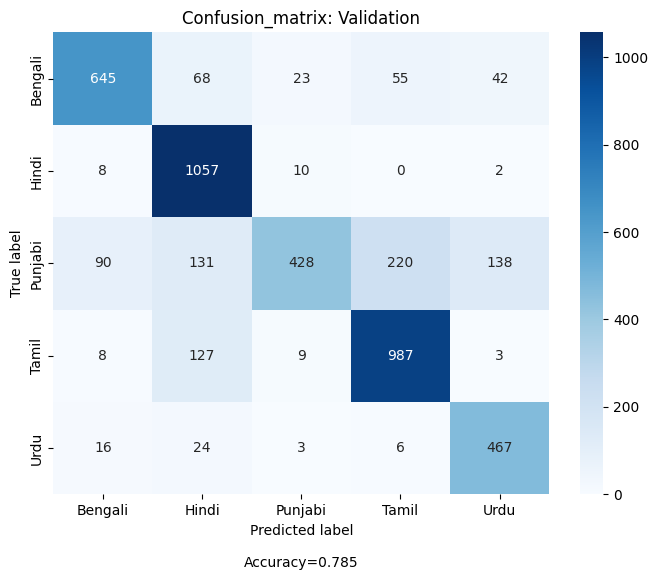

:::::Total vlidation loss 2.4452359003515656, Training accuracy 1.0, Validation accuracy 0.7847602364790891 after 44 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 45, Batch: 0, Loss: 0.006637413986027241, Accuracy:100.0%
Epoch: 45, Batch: 50, Loss: 0.02600438892841339, Accuracy:100.0%
Epoch: 45, Batch: 100, Loss: 0.015340528450906277, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 45, Batch: 0, Loss: 0.0024645566008985043, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 45, Batch: 50, Loss: 5.300638349581277e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 45, Batch: 100, Loss: 0.0006960522732697427, Accuracy:100.0%


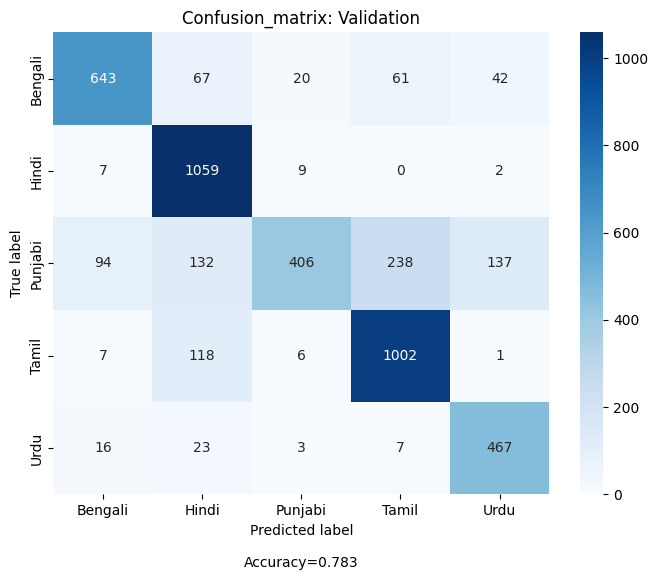

:::::Total vlidation loss 2.498652656894043, Training accuracy 1.0, Validation accuracy 0.7832275016422159 after 45 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 46, Batch: 0, Loss: 0.011004473082721233, Accuracy:100.0%
Epoch: 46, Batch: 50, Loss: 0.016731686890125275, Accuracy:100.0%
Epoch: 46, Batch: 100, Loss: 0.004259626846760511, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 46, Batch: 0, Loss: 0.00112277886364609, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 46, Batch: 50, Loss: 5.200072791922139e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 46, Batch: 100, Loss: 0.00251977751031518, Accuracy:100.0%


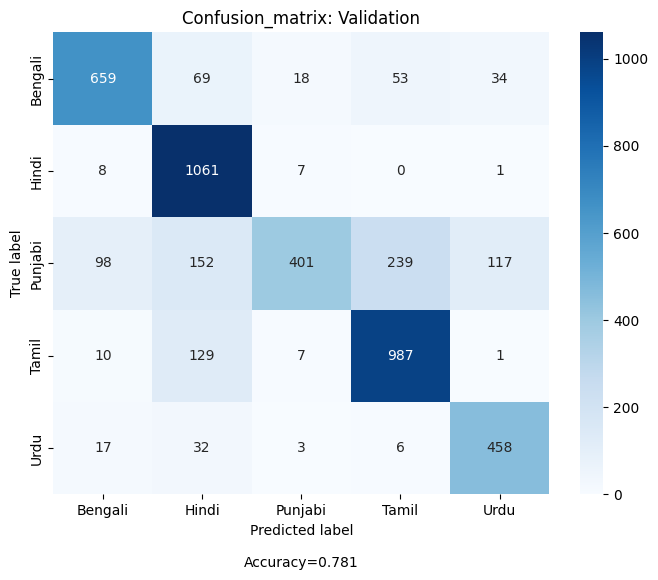

:::::Total vlidation loss 2.5694177084998984, Training accuracy 0.9999724092263547, Validation accuracy 0.7808189183271294 after 46 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 47, Batch: 0, Loss: 0.008250558748841286, Accuracy:100.0%
Epoch: 47, Batch: 50, Loss: 0.013260799460113049, Accuracy:100.0%
Epoch: 47, Batch: 100, Loss: 0.00596904382109642, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 47, Batch: 0, Loss: 0.005117019638419151, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 47, Batch: 50, Loss: 4.876025286648655e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 47, Batch: 100, Loss: 0.0001761517341947183, Accuracy:100.0%


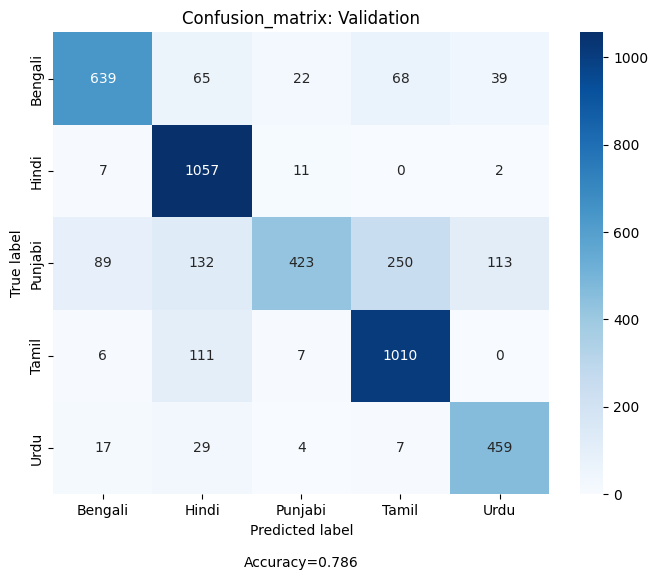

:::::Total vlidation loss 2.4647954117481943, Training accuracy 1.0, Validation accuracy 0.7856360849573024 after 47 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 48, Batch: 0, Loss: 0.01343891303986311, Accuracy:100.0%
Epoch: 48, Batch: 50, Loss: 0.01054837740957737, Accuracy:100.0%
Epoch: 48, Batch: 100, Loss: 0.010324503295123577, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 48, Batch: 0, Loss: 0.0031956296879798174, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 48, Batch: 50, Loss: 3.0806636459601577e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 48, Batch: 100, Loss: 0.0015676316106691957, Accuracy:100.0%


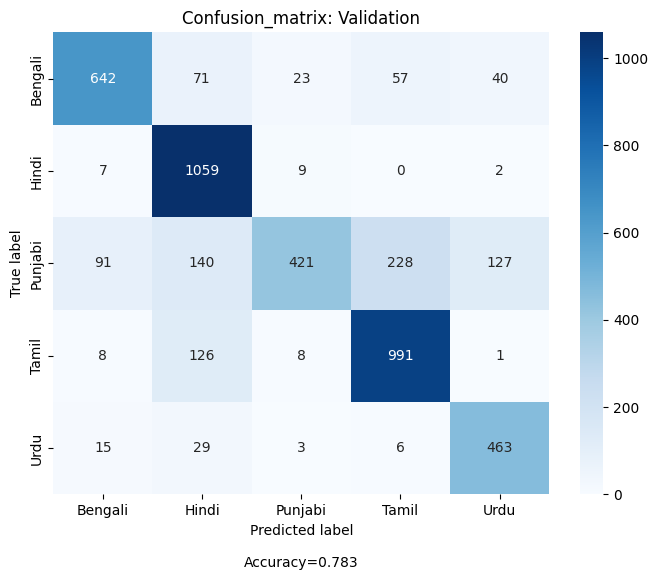

:::::Total vlidation loss 2.4671685662743474, Training accuracy 1.0, Validation accuracy 0.7830085395226626 after 48 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 49, Batch: 0, Loss: 0.006200458388775587, Accuracy:100.0%
Epoch: 49, Batch: 50, Loss: 0.0020050599705427885, Accuracy:100.0%
Epoch: 49, Batch: 100, Loss: 0.0027302864473313093, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 49, Batch: 0, Loss: 0.0011885840212926269, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 49, Batch: 50, Loss: 1.6651604255457642e-06, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 49, Batch: 100, Loss: 0.0031612443272024393, Accuracy:100.0%


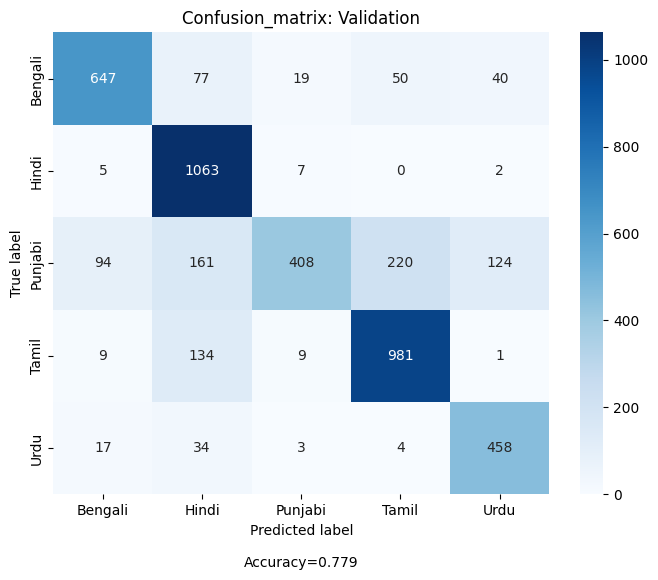

:::::Total vlidation loss 2.565061830392584, Training accuracy 1.0, Validation accuracy 0.7788482592511495 after 49 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############


: 

In [18]:
#For LR scheduler
import warnings
warnings.filterwarnings('ignore')
dest_path="/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/"
os.makedirs(dest_path,exist_ok=True)
#Languages=["Assamese","Bengali","Bodo","Dogri","English","Gujarati","Hindi","Kannada","Kashmiri","Konkani","Maithili","Manipuri","Malayalam","Marathi","Nepali","Odia","Punjabi","Sanskrit","Santali","Sindhi","Tamil","Telugu","Urdu"]
Languages=["Bengali","Hindi","Punjabi","Tamil","Urdu"]
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import cf_matrix
def train(dataloader_train,epoch):
    train_loss_list=[]
    train_acc_list=[]
    full_preds=[]
    full_gts=[]

    model.train()
    for i_batch, data in enumerate(dataloader_train, 0):
        features, labels = data
        #features=torch.transpose(features,0,2,1)
        #print(features.shape)
        #print(labels.shape)
        #features=minmax(features)
        features, labels = features.to(device).float(),labels.to(device).long()
        features.requires_grad = True
        optimizer.zero_grad()
        pred_logits = model(features)
        loss=model.get_loss(pred_logits,labels)
        posterior=model.get_posterior()
        #print(posterior.shape)
        #loss = loss_fun(pred_logits,labels)

        #print(pred_logits.shape)
        #LOSS=[]
        #for ii in range(features.shape[1]):
        #    loss = loss_fun(features[:,ii,:],labels)
        #    LOSS.append(loss)
        #loss=torch.mean(torch.tensor(LOSS))
        #loss.requires_grad_(True)
        loss.backward()
        optimizer.step()
        predictions = np.argmax(posterior.detach().cpu().numpy(),axis=1)
        if i_batch%50==0:
            #print(final_pred)
            acc = accuracy_score(predictions,labels.cpu())
            print(f"Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
        train_loss_list.append(loss.item())
        for pred in predictions:
            full_preds.append(pred)
        for lab in labels.detach().cpu().numpy():
            full_gts.append(lab)
    mean_acc = accuracy_score(full_gts,full_preds)
    mean_loss = np.mean(np.asarray(train_loss_list))
    return mean_acc
    print('Total training loss {} and training Accuracy {} after {} epochs'.format(mean_loss,mean_acc,epoch))
def validation(dataloader_val,epoch,train_accuracy):
    model.eval()
    with torch.no_grad():
        val_loss_list=[]
        full_preds=[]
        full_gts=[]
        for i_batch, data in enumerate(dataloader_val, 0):
            features, labels = data
            #features=torch.transpose(features,0,2,1)
            features, labels = features.to(device).float(),labels.to(device).long()
            pred_logits = model(features)
            #print(features.shape)
            #print(labels.shape)
            loss=model.get_loss(pred_logits,labels)
            posterior=model.get_posterior()
            #loss = loss_fun(pred_logits,labels)
            val_loss_list.append(loss.item())
            predictions = np.argmax(posterior.detach().cpu().numpy(),axis=1)
            if i_batch%50==0:
                #print(final_pred)
                acc = accuracy_score(predictions,labels.cpu())
                print(f"#####TEST--in-domain:::::Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
            for pred in predictions:
                full_preds.append(pred)
            for lab in labels.detach().cpu().numpy():
                full_gts.append(lab)

        mean_acc2 = accuracy_score(full_gts,full_preds)
        mean_loss2 = np.mean(np.asarray(val_loss_list))
        cm=confusion_matrix(full_gts,full_preds)
        cf_matrix.make_confusion_matrix(cm, percent=False, figsize=(8,6), categories=Languages, cbar=True, title="Confusion_matrix: Validation")
        plt.show()
        print(':::::Total vlidation loss {}, Training accuracy {}, Validation accuracy {} after {} epochs'.format(mean_loss2,train_accuracy, mean_acc2,epoch))
        print("#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############")
        model_save_path = os.path.join(dest_path,'IIITH_merged_original_Bhagya_ecapa_cms_'+str("{:.3f}".format(train_accuracy*100))+"_"+str("{:.3f}".format(mean_acc2*100))+"_"+str("{:.4f}".format(mean_loss2)))
        state_dict = {'model': model.state_dict(),'optimizer': optimizer.state_dict(),'epoch': epoch}
        torch.save(state_dict, model_save_path)
        return loss

if __name__ == '__main__':
    for epoch in range(50):
        mean_acc=train(trainloader,epoch)
        val_loss=validation(testloader1,epoch,mean_acc)
        scheduler.step(val_loss)
        #testing(testloader2,epoch,mean_acc)
        #testing(testloader3,epoch,mean_acc)

In [36]:
X_train.shape

(36244, 20, 300)

In [39]:
y_train.shape

(36244,)